#Librairies

In [ ]:
!pip install pylast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the required libraries
import pathlib
import os
import re
import time
import ast
import pylast
import pandas as pd
from time import sleep
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from collections import Counter



In [ ]:
HOME = os.getcwd()
print(HOME)

/content


#Load CSV files

In [410]:
# Define file paths
csv_file_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/songs/full_songs_genres.csv")
tagged_file = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/songs/spotify_songs_with_tags.csv")
cleaned_file_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/songs/full_clean.csv") #clean loudness and tempo abnormality
final_file_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/songs/full_clean_normalized.csv")#balanced genres version, with loudness and tempo normalization, no abnormality

#Data preparation

##Dataset enhancement with Last.fm tags (optionnal)

In [ ]:
# Your API credentials
API_KEY = ""
API_SECRET = ""
username = ""
password_hash = pylast.md5("")

# Connect to Last.fm
network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET,
                                username=username, password_hash=password_hash)

# Load dataset
df = pd.read_csv(csv_file_path)

tag_cache = {}

def get_top_tags(artist_name, track_name, limit=6, delay=0.3):
    key = (str(artist_name).lower(), str(track_name).lower())
    if key in tag_cache:
        return tag_cache[key]

    try:
        track = network.get_track(artist_name, track_name)
        tags = track.get_top_tags(limit=limit)
        time.sleep(delay)
        result = [tag.item.get_name().lower() for tag in tags]
        tag_cache[key] = result
        return result
    except Exception as e:
        print(f"Error for '{track_name}' by '{artist_name}': {e}")
        time.sleep(delay)
        return []


In [ ]:
batch_size = 500

# Check for resume
if os.path.exists(tagged_file):
    processed_df = pd.read_csv(tagged_file)
    processed_count = len(processed_df)
    print(f"🔁 Resuming from song {processed_count}")
else:
    processed_count = 0

# Process unprocessed rows
for i in range(processed_count, len(df), batch_size):
    batch = df.iloc[i:i + batch_size].copy()
    print(f"⏳ Processing songs {i} to {i+len(batch)}...")

    batch["tags"] = batch.apply(
        lambda row: get_top_tags(row["track_artist"], row["track_name"]), axis=1)

    # Save batch
    header = not os.path.exists(tagged_file)
    batch.to_csv(tagged_file, mode='a', index=False, header=header)

    print(f"✅ Batch {i}-{i+len(batch)} saved.")


#Dataset cleaning & balancing

##Loudness and tempo analysis before normalization

In [444]:
# Load your dataset
df = pd.read_csv(csv_file_path)

In [445]:
ml = df["loudness"].max()
mnl = df["loudness"].min()
mt = df["tempo"].max()
mnt = df["tempo"].min()
print(f"max loudness : {ml}\n min loudness : {mnl}")
print(f"max tempo : {mt}\n min tempo :{mnt}")


max loudness : 4.532
 min loudness : -49.531
max tempo : 243.372
 min tempo :0.0


In [446]:
def check_invalid_values(df):
    # Check for invalid tempo (values should be within [40, 250])
    invalid_tempo = df[(df['tempo'] <= 0) | (df['tempo'] > 250)]
    invalid_tempo_count = invalid_tempo.shape[0]
    invalid_tempo_indices = invalid_tempo.index.tolist()

    # Check for invalid loudness (values should be within [-60, 0] dB)
    invalid_loudness = df[(df['loudness'] > 0) | (df['loudness'] < -60)]
    #invalid_loudness = df[(df['loudness'] > 0)]
    invalid_loudness_count = invalid_loudness.shape[0]
    invalid_loudness_indices = invalid_loudness.index.tolist()

    # Output the results
    print(f"Invalid Tempo Count: {invalid_tempo_count}")
    print(f"Invalid Tempo Indices: {invalid_tempo_indices}")
    print(f"Invalid Loudness Count: {invalid_loudness_count}")
    print(f"Invalid Loudness Indices: {invalid_loudness_indices}")

    return {
        'invalid_tempo_count': invalid_tempo_count,
        'invalid_tempo_indices': invalid_tempo_indices,
        'invalid_loudness_count': invalid_loudness_count,
        'invalid_loudness_indices': invalid_loudness_indices
    }


# Checking invalid values and counting them
invalid_values = check_invalid_values(df)


Invalid Tempo Count: 158
Invalid Tempo Indices: [2718, 35151, 35332, 35546, 65996, 66046, 66055, 66099, 76493, 76582, 76745, 77072, 81056, 90024, 90044, 103033, 108585, 109806, 109808, 109813, 109822, 109823, 109824, 109825, 109826, 109830, 109848, 109863, 109865, 109993, 109995, 110004, 110005, 110030, 110033, 110034, 110035, 110040, 110051, 110052, 110062, 110082, 110091, 110094, 110095, 110100, 110105, 110106, 110107, 110126, 110134, 110135, 110139, 110140, 110141, 110142, 110143, 110146, 110149, 110157, 110159, 110161, 110162, 110163, 110177, 110180, 110181, 110182, 110202, 110205, 110208, 110212, 110213, 110244, 110248, 110255, 110257, 110278, 110280, 110282, 110287, 110298, 110299, 110300, 110301, 110303, 110305, 110328, 110334, 110338, 110342, 110345, 110350, 110354, 110356, 110360, 110362, 110363, 110381, 110382, 110384, 110386, 110396, 110397, 110398, 110411, 110428, 110431, 110432, 110437, 110446, 110447, 110453, 110455, 110463, 110494, 110498, 110508, 110509, 110533, 110539,

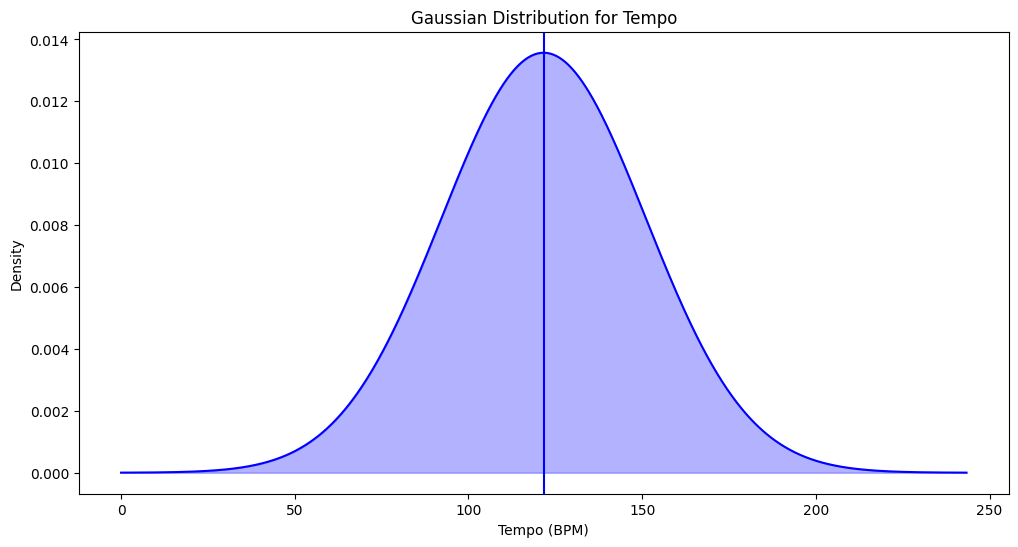

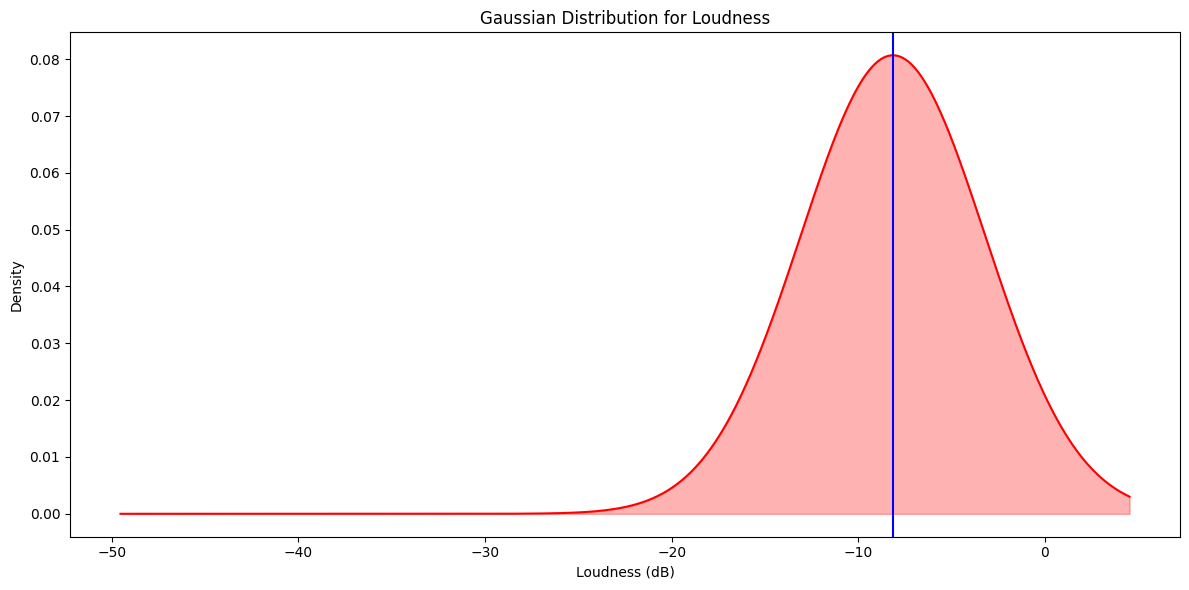

average loudness :-8.145440201611589
loudness standard deviation: 4.944194078848395
average tempo :121.64483269174306
tempo standard deviation: 29.393613781870407


In [447]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calculate mean and std for both 'tempo' and 'loudness'
tempo_mean = df['tempo'].mean()
tempo_std = df['tempo'].std()
loudness_mean = df['loudness'].mean()
loudness_std = df['loudness'].std()

# Create a range of values for plotting the Gaussian distribution
tempo_range = np.linspace(df['tempo'].min(), df['tempo'].max(), 1000)
loudness_range = np.linspace(df['loudness'].min(), df['loudness'].max(), 1000)

# Calculate the probability density function (PDF) for both features
tempo_pdf = norm.pdf(tempo_range, tempo_mean, tempo_std)
loudness_pdf = norm.pdf(loudness_range, loudness_mean, loudness_std)

# Plotting


# Plot Gaussian for tempo
#plt.subplot(1, 2, 1)
plt.figure(figsize=(12, 6))
plt.plot(tempo_range, tempo_pdf, label="Gaussian for Tempo", color='blue')
plt.fill_between(tempo_range, tempo_pdf, color='blue', alpha=0.3)
plt.title('Gaussian Distribution for Tempo')
plt.xlabel('Tempo (BPM)')
plt.axvline(x = tempo_mean, color = 'b', label = 'average loudness')
plt.ylabel('Density')

# Plot Gaussian for loudness
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
plt.plot(loudness_range, loudness_pdf, label="Gaussian for Loudness", color='red')
plt.fill_between(loudness_range, loudness_pdf, color='red', alpha=0.3)
plt.title('Gaussian Distribution for Loudness')
plt.xlabel('Loudness (dB)')
plt.axvline(x = loudness_mean, color = 'b', label = 'average loudness')
plt.ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()
print(f"average loudness :{loudness_mean}")
print(f"loudness standard deviation: {loudness_std}")
print(f"average tempo :{tempo_mean}")
print(f"tempo standard deviation: {tempo_std}")



In [448]:
#  Calculate 90% confidence interval
#z_score = norm.ppf(0.95)
#  Calculate 95% confidence interval
z_score = norm.ppf(0.975)

# Calculate the 90% confidence interval for tempo and loudness
tempo_interval = (tempo_mean - z_score * tempo_std, tempo_mean + z_score * tempo_std)
loudness_interval = (loudness_mean - z_score * loudness_std, loudness_mean + z_score * loudness_std)

# Output the results
print(f"95% Confidence Interval for Tempo (BPM): {tempo_interval}")
print(f"95% Confidence Interval for Loudness (dB): {loudness_interval}")

95% Confidence Interval for Tempo (BPM): (np.float64(64.0344083037969), np.float64(179.25525707968922))
95% Confidence Interval for Loudness (dB): (np.float64(-17.83588252873063), np.float64(1.5450021255074535))


📦 Total tracks: 122613
⚠️ Tracks outside 95% CI for tempo or loudness: 10254 (8.36%)

🎶 Genre distribution among outliers vs full dataset:
                           All Tracks %  Outliers %  % Change if Removed
track_genre                                                             
sleep                          0.815574    7.938366             7.122791
new-age                        0.722599    5.071192             4.348593
classical                      0.597000    4.720109             4.123109
piano                          0.727492    4.720109             3.992617
ambient                        0.581504    3.939926             3.358421
...                                 ...         ...                  ...
party                          0.808234    0.078018            -0.730216
drum-and-bass                  0.787845    0.048761            -0.739083
pop                            1.346513    0.536376            -0.810137
electro house                  1.019468    0.175541       

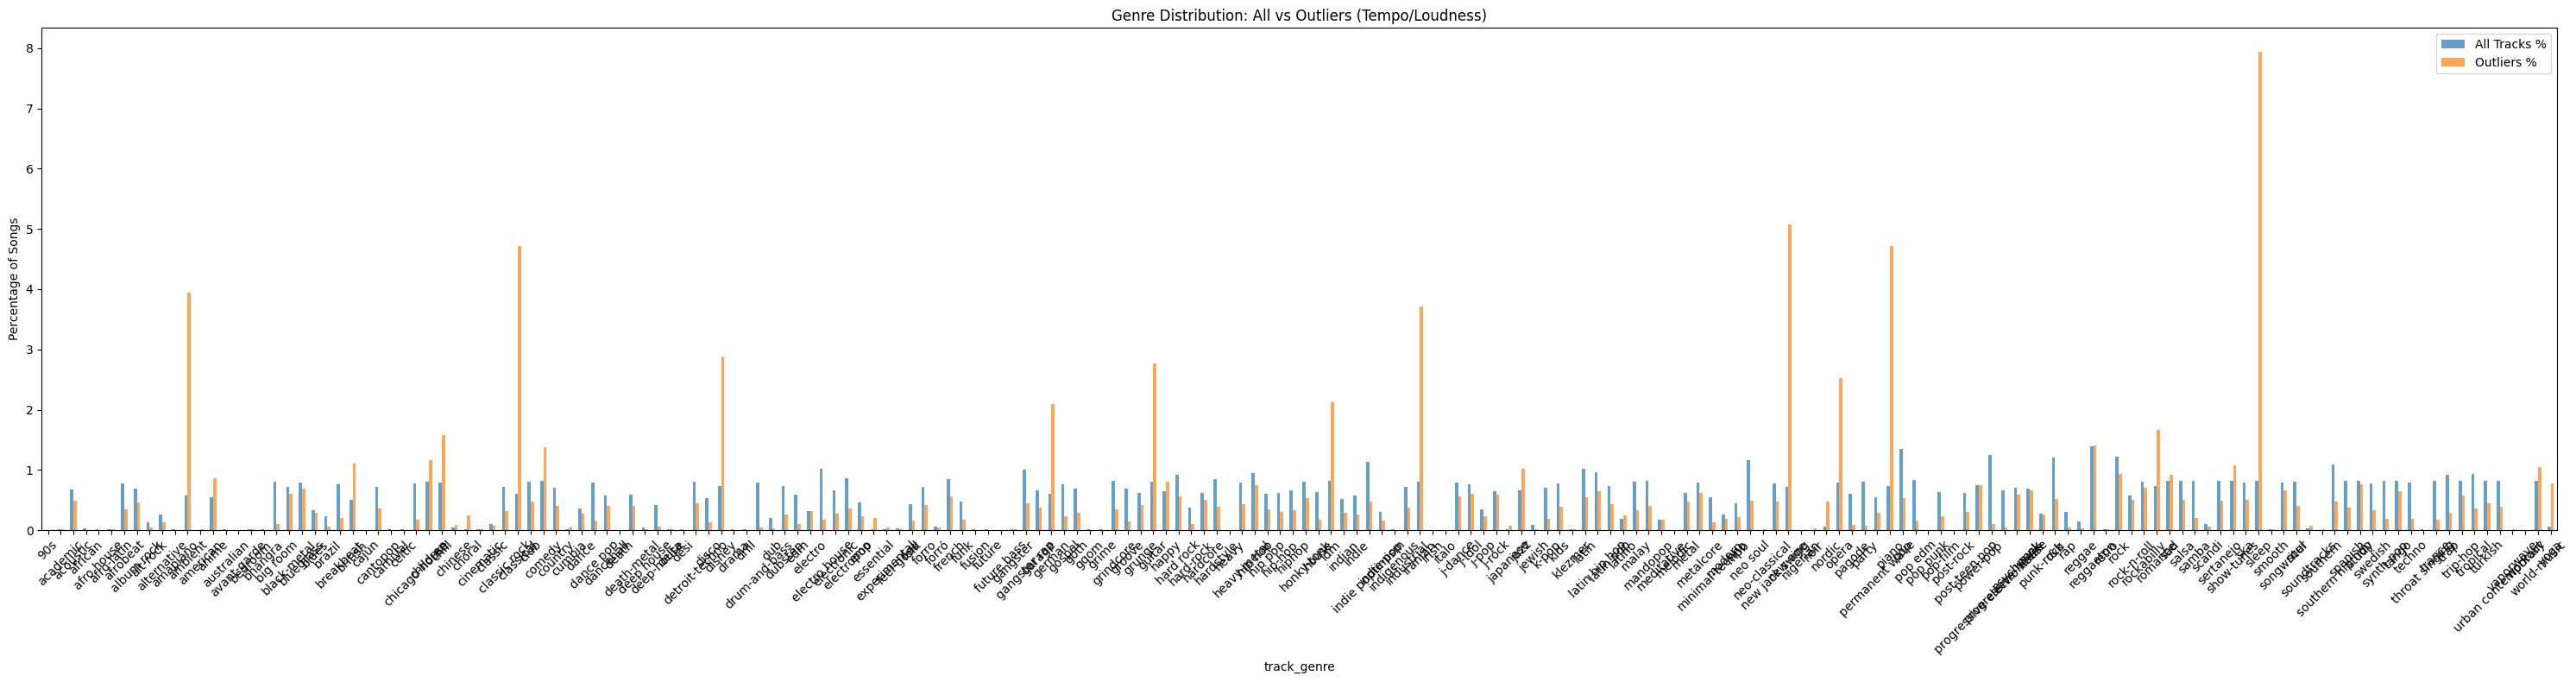

In [ ]:
tempo_mean = df['tempo'].mean()
tempo_std = df['tempo'].std()
tempo_ci = (tempo_mean - z_score * tempo_std, tempo_mean + z_score * tempo_std)

loudness_mean = df['loudness'].mean()
loudness_std = df['loudness'].std()
loudness_ci = (loudness_mean - z_score * loudness_std, loudness_mean + z_score * loudness_std)

# Identify outliers
outliers = df[
    (df['tempo'] < tempo_ci[0]) | (df['tempo'] > tempo_ci[1]) |
    (df['loudness'] < loudness_ci[0]) | (df['loudness'] > loudness_ci[1])
]

# Stats
num_outliers = len(outliers)
total = len(df)
percent = (num_outliers / total) * 100

print(f"📦 Total tracks: {total}")
print(f"⚠️ Tracks outside 95% CI for tempo or loudness: {num_outliers} ({percent:.2f}%)")

# Genre breakdown
genre_outliers = outliers['track_genre'].value_counts(normalize=True) * 100
genre_total = df['track_genre'].value_counts(normalize=True) * 100

genre_comparison = pd.DataFrame({
    'All Tracks %': genre_total,
    'Outliers %': genre_outliers
}).fillna(0)

genre_comparison['% Change if Removed'] = genre_comparison['Outliers %'] - genre_comparison['All Tracks %']

print("\n🎶 Genre distribution among outliers vs full dataset:")
print(genre_comparison.sort_values('% Change if Removed', ascending=False))



genre_comparison[['All Tracks %', 'Outliers %']].plot(kind='bar', figsize=(30,8), alpha=0.7)
plt.title("Genre Distribution: All vs Outliers (Tempo/Loudness)")
plt.ylabel("Percentage of Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [451]:
# Calculate 95% Confidence Interval for Tempo and Loudness
tempo_mean = df['tempo'].mean()
tempo_std = df['tempo'].std()
tempo_ci = (tempo_mean - z_score * tempo_std, tempo_mean + z_score * tempo_std)

loudness_mean = df['loudness'].mean()
loudness_std = df['loudness'].std()
loudness_ci = (loudness_mean - z_score * loudness_std, loudness_mean + z_score * loudness_std)

# Filter out rows outside the 95% confidence interval for both tempo and loudness
df_cleaned = df[
    (df['tempo'] >= tempo_ci[0]) & (df['tempo'] <= tempo_ci[1]) &
    (df['loudness'] >= loudness_ci[0]) & (df['loudness'] <= loudness_ci[1])
]

# Remove the columns 'normalized_tempo' and 'normalized_loudness'
#df_cleaned = df_cleaned.drop(columns=['normalized_tempo', 'normalized_loudness'])

# Save cleaned dataset to CSV
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved as {cleaned_file_path} with {len(df_cleaned)} rows.")


Cleaned dataset saved as /content/drive/MyDrive/Colab Notebooks/songs/full_clean.csv with 112358 rows.


In [452]:
# Load your dataset
df = pd.read_csv(cleaned_file_path)
new_ml = df["loudness"].max()
new_mnl = df["loudness"].min()
new_mt = df["tempo"].max()
new_mnt = df["tempo"].min()
print(f"max loudness : {new_ml}\n min loudness : {new_mnl}")
print(f"max tempo : {new_mt}\n min tempo :{new_mnt}")


max loudness : 1.416
 min loudness : -17.835
max tempo : 179.243
 min tempo :64.049


In [453]:
invalid_values = check_invalid_values(df)
# Remove songs with loudness > 0 dB
df_cleaned = df[df['loudness'] <= 0].copy()

# Optional: confirm the removal
print(f"Dataset cleaned: {len(df) - len(df_cleaned)} rows removed.")
print(f"New dataset size: {len(df_cleaned)} rows.")
df_cleaned.to_csv(cleaned_file_path, index=False)
invalid_values = check_invalid_values(df_cleaned)

Invalid Tempo Count: 0
Invalid Tempo Indices: []
Invalid Loudness Count: 66
Invalid Loudness Indices: [2299, 7991, 10013, 15398, 19423, 22331, 25483, 25490, 25516, 25520, 26146, 27152, 27974, 36809, 37341, 37540, 42143, 42419, 48670, 48673, 48715, 48721, 48731, 48869, 48889, 48897, 49141, 49143, 49153, 49261, 49319, 49484, 49586, 50042, 50144, 50606, 50715, 54963, 54996, 55070, 55090, 55188, 55869, 62061, 63150, 63191, 67364, 67684, 67722, 68330, 70027, 70473, 70958, 71094, 71098, 71171, 72562, 73752, 74046, 74293, 77963, 87704, 88436, 90720, 108298, 108468]
Dataset cleaned: 66 rows removed.
New dataset size: 112292 rows.
Invalid Tempo Count: 0
Invalid Tempo Indices: []
Invalid Loudness Count: 0
Invalid Loudness Indices: []


##Normalization & Balancing

In [539]:
#Preparation pipeline
def normalize_features(df, features, force=False):
    df = df.copy()
    for feature in features:
        if not force and df[feature].min() >= 0 and df[feature].max() <= 1:
            continue
        min_val = df[feature].min()
        max_val = df[feature].max()
        df[f"normalized_{feature}"] = (df[feature] - min_val) / (max_val - min_val)
    return df

def circular_encode_music_keys(df):
    df = df.copy()
    df["key_sin"] = np.sin(2 * np.pi * df["key"] / 12)
    df["key_cos"] = np.cos(2 * np.pi * df["key"] / 12)
    return df

def normalize_loudness_tempo(df):
    df = df.copy()
    loudness_min = -60  # typical quietest
    loudness_max = 0    # digital ceiling

    tempo_min = 40
    tempo_max = 230

    # Normalize loudness
    df["normalized_loudness"] = (df["loudness"] - loudness_min) / (loudness_max - loudness_min)

    # Normalize tempo
    df["normalized_tempo"] = (df["tempo"] - tempo_min) / (tempo_max - tempo_min)

    # Create tempo label (optional for analysis)
    def tempo_category(bpm):
      if bpm < 60:
        return "largo"
      elif bpm < 76:
        return "adagio"
      elif bpm < 108:
        return "andante"
      elif bpm < 120:
        return "moderato"
      elif bpm < 168:
        return "allegro"
      else:
        return "presto"
    df["tempo_label"] = df["tempo"].apply(tempo_category)

    return df

"""def balanced_subgenre_sampling(df, main_genre_col="playlist_genre", subgenre_col="playlist_subgenre", max_per_subgenre=500):
    df = df.copy()
    balanced_df = pd.DataFrame()
    for genre in df[main_genre_col].unique():
        genre_group = df[df[main_genre_col] == genre]
        subgenres = genre_group[subgenre_col].unique()
        for sub in subgenres:
            sub_df = genre_group[genre_group[subgenre_col] == sub]
            sample = sub_df.sample(n=min(len(sub_df), max_per_subgenre), random_state=42)
            balanced_df = pd.concat([balanced_df, sample])
    return balanced_df.reset_index(drop=True)

def preprocess_dataset(df, balance=True, force_normalize=False, max_per_subgenre=500):
    print("🔄 Starting preprocessing...")

    norm_features = [
        "acousticness", "danceability", "energy",
        "instrumentalness", "liveness", "speechiness", "valence"
    ]
    df = normalize_features(df, norm_features, force=force_normalize)
    df = circular_encode_music_keys(df)
    df = normalize_loudness_tempo(df)
    # Ensure mode is treated as categorical
    df["mode"] = df["mode"].astype("category")
    df['final_genre'] = df['playlist_subgenre']

    if balance:
        print("⚖️ Balancing dataset by subgenre within each genre...")
        df = balanced_subgenre_sampling(
            df,
            main_genre_col="playlist_genre",
            subgenre_col="playlist_subgenre",
            max_per_subgenre=max_per_subgenre
        )

    # Preserve essential genre information
    essential_columns = ["playlist_genre", "playlist_subgenre"]
    for col in essential_columns:
        if col not in df.columns:
            df[col] = None

    print("✅ Preprocessing complete.")
    return df"""

def balanced_genre_sampling(df, genre_col="final_genre", max_per_genre=500):
    df = df.copy()
    balanced_df = pd.DataFrame()

    for genre in df[genre_col].dropna().unique():
        genre_group = df[df[genre_col] == genre]
        sample = genre_group.sample(n=min(len(genre_group), max_per_genre), random_state=42)
        balanced_df = pd.concat([balanced_df, sample], ignore_index=True)

    return balanced_df


def preprocess_dataset(df, balance=True, force_normalize=False, max_per_genre=500):
    print("🔄 Starting preprocessing...")

    norm_features = [
        "acousticness", "danceability", "energy",
        "instrumentalness", "liveness", "speechiness", "valence"
    ]
    df = normalize_features(df, norm_features, force=force_normalize)
    df = circular_encode_music_keys(df)
    df = normalize_loudness_tempo(df)
    # Ensure mode is treated as categorical
    df["mode"] = df["mode"].astype("category")
    df['final_genre'] = df['playlist_subgenre']

    if balance:
        print("⚖️ Balancing dataset by subgenre within each genre...")
        df = balanced_genre_sampling(df, genre_col="final_genre", max_per_genre=500)

    # Preserve essential genre information
    """essential_columns = ["playlist_genre", "playlist_subgenre","track_genre"]
    for col in essential_columns:
        if col not in df.columns:
            df[col] = None"""

    print("✅ Preprocessing complete.")
    return df


In [540]:
# Pipeline execution
df = pd.read_csv(cleaned_file_path)
print("track_genre:", df['track_genre'].nunique())
print("playlist_genre:", df['playlist_genre'].nunique())
print("playlist_subgenre:", df['playlist_subgenre'].nunique())

overlap = (df['track_genre'].str.lower() == df['playlist_subgenre'].str.lower()).mean()
print(f"Overlap between track_genre and playlist_subgenre: {overlap:.2%}")

processed_df = preprocess_dataset(df, balance=True)
processed_df.to_csv(final_file_path, index=False)

print(f"✅ Optimized dataset saved to: {final_file_path}")

track_genre: 196
playlist_genre: 123
playlist_subgenre: 196
Overlap between track_genre and playlist_subgenre: 100.00%
🔄 Starting preprocessing...
⚖️ Balancing dataset by subgenre within each genre...
✅ Preprocessing complete.
✅ Optimized dataset saved to: /content/drive/MyDrive/Colab Notebooks/songs/full_clean_normalized.csv


#Load final dataset

In [541]:
df = pd.read_csv(final_file_path)

#Dataset analysis

##Genre analysis

In [542]:
# Flatten all tags into one big list
cleaned_genres = df['final_genre'].dropna().str.strip().str.lower()
genre_counts = Counter(cleaned_genres)
t=50
top_genres = genre_counts.most_common(t)
top_genres

[('dance pop', 500),
 ('post-teen pop', 500),
 ('electropop', 500),
 ('indie poptimism', 500),
 ('hip hop', 500),
 ('southern hip hop', 500),
 ('gangster rap', 500),
 ('trap', 500),
 ('album rock', 500),
 ('classic rock', 500),
 ('permanent wave', 500),
 ('hard rock', 500),
 ('tropical', 500),
 ('latin pop', 500),
 ('reggaeton', 500),
 ('latin hip hop', 500),
 ('urban contemporary', 500),
 ('hip pop', 500),
 ('new jack swing', 500),
 ('neo soul', 500),
 ('electro house', 500),
 ('big room', 500),
 ('pop edm', 500),
 ('progressive electro house', 500),
 ('hip-hop', 500),
 ('indie', 500),
 ('chill', 500),
 ('anime', 500),
 ('french', 500),
 ('techno', 500),
 ('funk', 500),
 ('pop', 500),
 ('latin', 500),
 ('tango', 500),
 ('hardstyle', 500),
 ('spanish', 500),
 ('samba', 500),
 ('rock', 500),
 ('edm', 500),
 ('hiphop', 500),
 ('r&b', 500),
 ('acoustic', 500),
 ('afrobeat', 500),
 ('black-metal', 500),
 ('bluegrass', 500),
 ('breakbeat', 500),
 ('british', 500),
 ('cantopop', 500),
 ('chi

In [543]:
print("track_genre:", df['track_genre'].nunique())
print("playlist_genre:", df['playlist_genre'].nunique())
print("playlist_subgenre:", df['playlist_subgenre'].nunique())

overlap = (df['track_genre'].str.lower() == df['playlist_subgenre'].str.lower()).mean()
print(f"Overlap between track_genre and playlist_subgenre: {overlap:.2%}")


track_genre: 196
playlist_genre: 123
playlist_subgenre: 196
Overlap between track_genre and playlist_subgenre: 100.00%


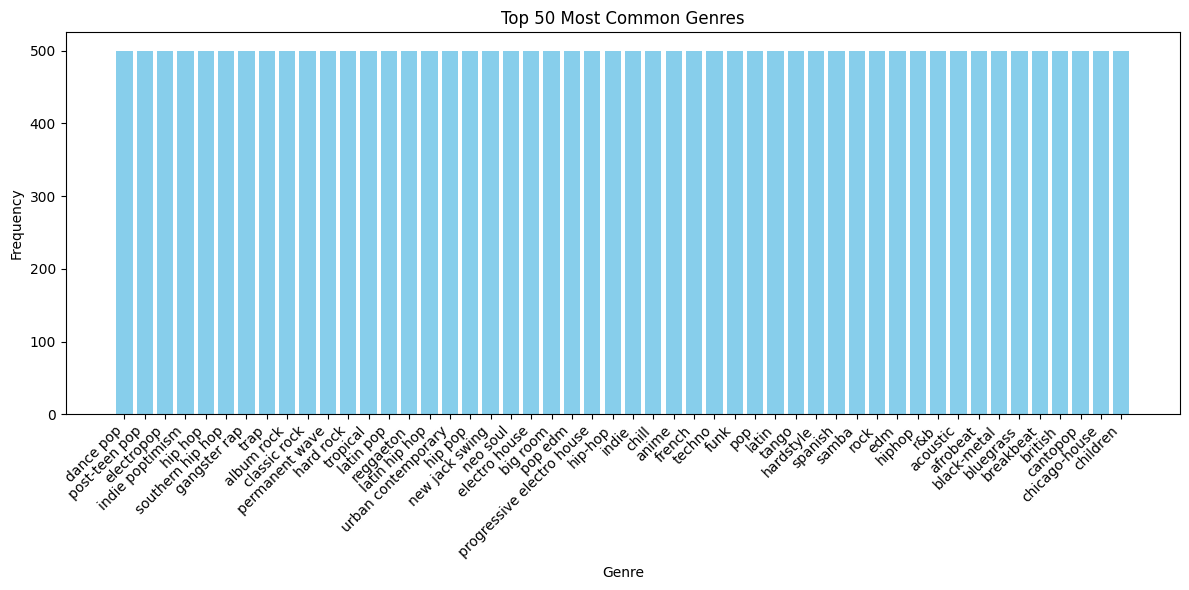

In [544]:
import matplotlib.pyplot as plt

genres, counts = zip(*top_genres)

plt.figure(figsize=(12, 6))
plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {t} Most Common Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


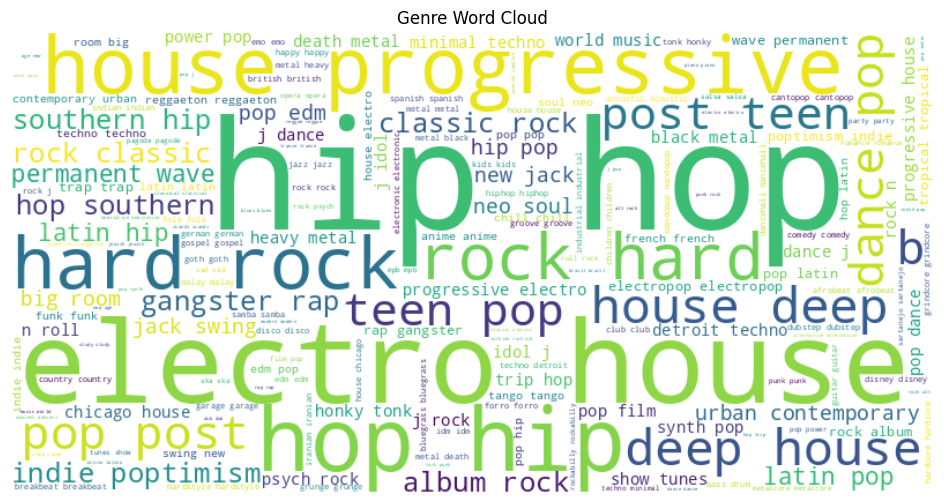

In [545]:
from wordcloud import WordCloud

genre_string = " ".join(cleaned_genres)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genre_string)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Genre Word Cloud")
plt.show()


##Scree plot for feature optimization

In [546]:
df = pd.read_csv(final_file_path)
normalized_features=df[[
    'danceability', 'energy',
    'valence', 'normalized_tempo', 'normalized_loudness',
    'acousticness', 'instrumentalness', 'liveness', 'speechiness'
]]

"""normalized_features=df[[
    'danceability', 'energy', 'key_cos', 'key_sin',
    'valence', 'normalized_tempo', 'normalized_loudness',
    'acousticness', 'instrumentalness', 'liveness', 'speechiness',
]]"""

print(normalized_features.isna().sum())

print(np.isinf(normalized_features).sum())
bad_rows = normalized_features[normalized_features.isna().any(axis=1)]
print(bad_rows)

inf_rows = normalized_features[np.isinf(normalized_features).any(axis=1)]
print(inf_rows)

danceability           0
energy                 0
valence                0
normalized_tempo       0
normalized_loudness    0
acousticness           0
instrumentalness       0
liveness               0
speechiness            0
dtype: int64
danceability           0
energy                 0
valence                0
normalized_tempo       0
normalized_loudness    0
acousticness           0
instrumentalness       0
liveness               0
speechiness            0
dtype: int64
Empty DataFrame
Columns: [danceability, energy, valence, normalized_tempo, normalized_loudness, acousticness, instrumentalness, liveness, speechiness]
Index: []
Empty DataFrame
Columns: [danceability, energy, valence, normalized_tempo, normalized_loudness, acousticness, instrumentalness, liveness, speechiness]
Index: []


In [588]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(normalized_features)
explained_variance = pca.explained_variance_ratio_


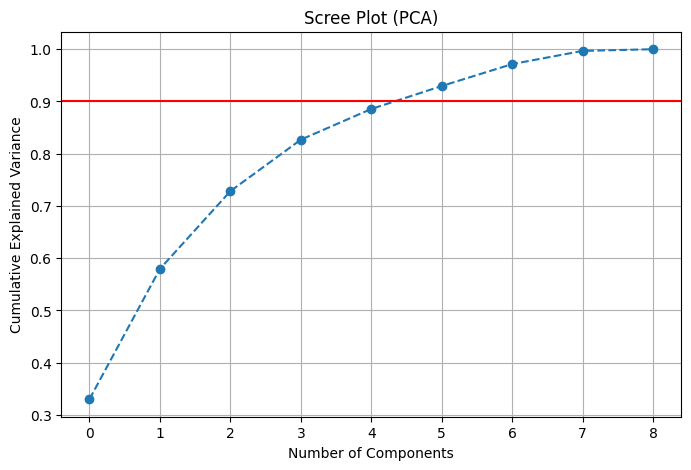

In [589]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot (PCA)')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-')  # Mark the 90% threshold
plt.show()


In [590]:
threshold = 0.90
optimal_n = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1
print(f"Optimal n={optimal_n}")
pca = PCA(n_components=optimal_n)
reduced_features = pca.fit_transform(normalized_features)


Optimal n=6


#Clustering

In [591]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess features
#audio_features = ['danceability', 'energy', 'key_cos', 'key_sin','valence', 'normalized_tempo','normalized_loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
audio_features = ['danceability', 'energy','valence', 'normalized_tempo','normalized_loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
X_audio = df[audio_features]
X_audio = X_audio.dropna()
X_audio_scaled = StandardScaler().fit_transform(X_audio)
c=15

##Clustering audio-features only

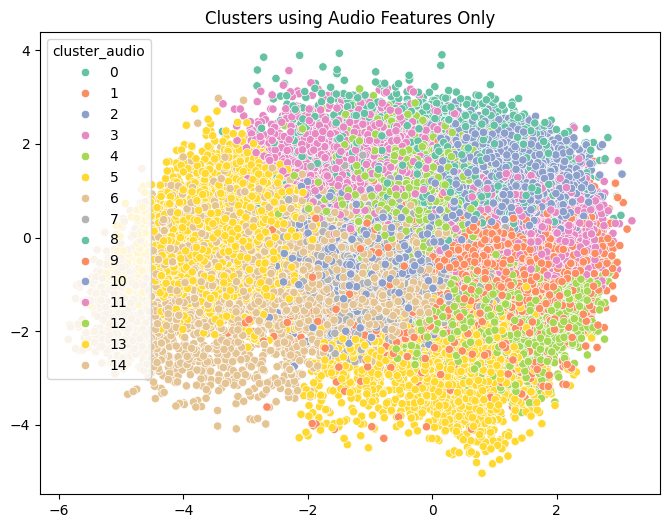

In [551]:
kmeans_audio = KMeans(n_clusters=c, random_state=42)
df['cluster_audio'] = kmeans_audio.fit_predict(X_audio_scaled)

# Optional: visualize audio-only clustering
pca1 = PCA(n_components=2)
reduced_audio = pca1.fit_transform(X_audio_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_audio[:,0], y=reduced_audio[:,1], hue=df['cluster_audio'], palette='Set2')
plt.title('Clusters using Audio Features Only')
plt.show()


##Clustering with reduced audio features

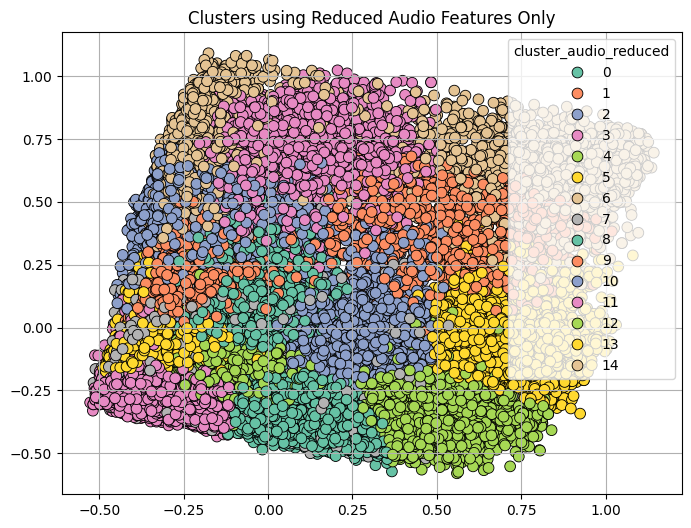

(67077, 6)
(67077, 31)
67077
Reduced features shape: (67077, 6)
Dataframe shape: (67077, 31)
Number of reduced features: 67077


In [592]:
kmeans_audio_reduced = KMeans(n_clusters=c, random_state=42)
df['cluster_audio_reduced'] = kmeans_audio_reduced.fit_predict(reduced_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=df['cluster_audio_reduced'], palette='Set2',s=60,edgecolor='k')
plt.title('Clusters using Reduced Audio Features Only')
plt.grid(True)
plt.show()

print(reduced_features.shape)
print(df.shape)
print(len(reduced_features))

print(f"Reduced features shape: {reduced_features.shape}")
print(f"Dataframe shape: {df.shape}")
print(f"Number of reduced features: {len(reduced_features)}")
centroids_pca = kmeans_audio_reduced.cluster_centers_

##Combine Audio-features + Genre vectors


Vectorize genres

In [553]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, binary=True)
X_tags = vectorizer.fit_transform(df['final_genre'])


Combine Audio-features + Tag vectors

In [554]:
from scipy.sparse import hstack

# Combine scaled audio + sparse genre vectors
from sklearn.preprocessing import MinMaxScaler
X_combined = hstack([X_tags, MinMaxScaler().fit_transform(X_audio)])


Clustering with combined features

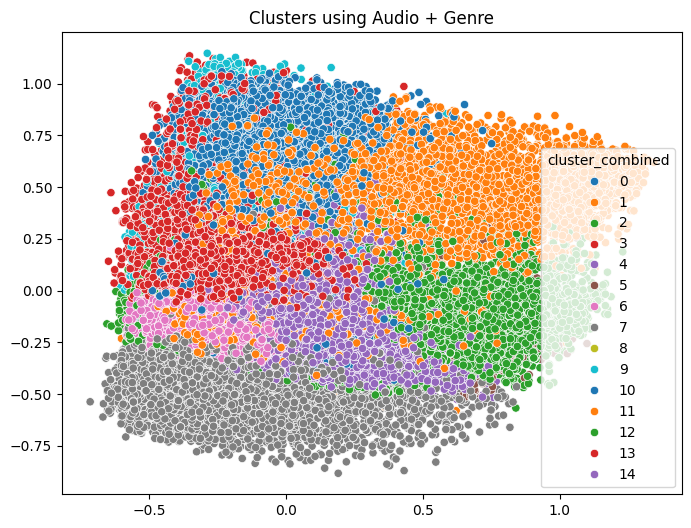

In [555]:
kmeans_both = KMeans(n_clusters=c, random_state=42)
df['cluster_combined'] = kmeans_both.fit_predict(X_combined)

# PCA on the tag+audio combined
pca2 = PCA(n_components=2)
reduced_combined = pca2.fit_transform(X_combined.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_combined[:,0], y=reduced_combined[:,1], hue=df['cluster_combined'], palette='tab10')
plt.title('Clusters using Audio + Genre')
plt.show()


##Compare clusters

Compare tag distributions per cluster

In [556]:
from collections import Counter
import numpy as np

def top_genre_for_cluster(df, cluster_col):
    print(f"📌 Top genres for each cluster based on '{cluster_col}'")
    for i in sorted(df[cluster_col].dropna().unique()):
        cluster_genres = df['final_genre']
        top_genres = Counter(cluster_genres).most_common(10)
        print(f"Cluster {i}: {[genre for genre, _ in top_genres]}")

top_genre_for_cluster(df, 'cluster_audio')
top_genre_for_cluster(df, 'cluster_combined')
top_genre_for_cluster(df, 'cluster_audio_reduced')


📌 Top genres for each cluster based on 'cluster_audio'
Cluster 0: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock']
Cluster 1: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock']
Cluster 2: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock']
Cluster 3: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock']
Cluster 4: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock']
Cluster 5: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', '

Genre distribution per cluster

In [557]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_genre_distribution(df, cluster_col, top_n=10):
    genre_counts = df.groupby([cluster_col, 'final_genre']).size().reset_index(name='count')
    top_genres = df['final_genre'].value_counts().nlargest(top_n).index

    # Filter to top genres
    genre_counts = genre_counts[genre_counts['final_genre'].isin(top_genres)]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=genre_counts,
        x=cluster_col,
        y='count',
        hue='final_genre'
    )
    plt.title(f"Genre Distribution across {cluster_col}")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Songs")
    plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


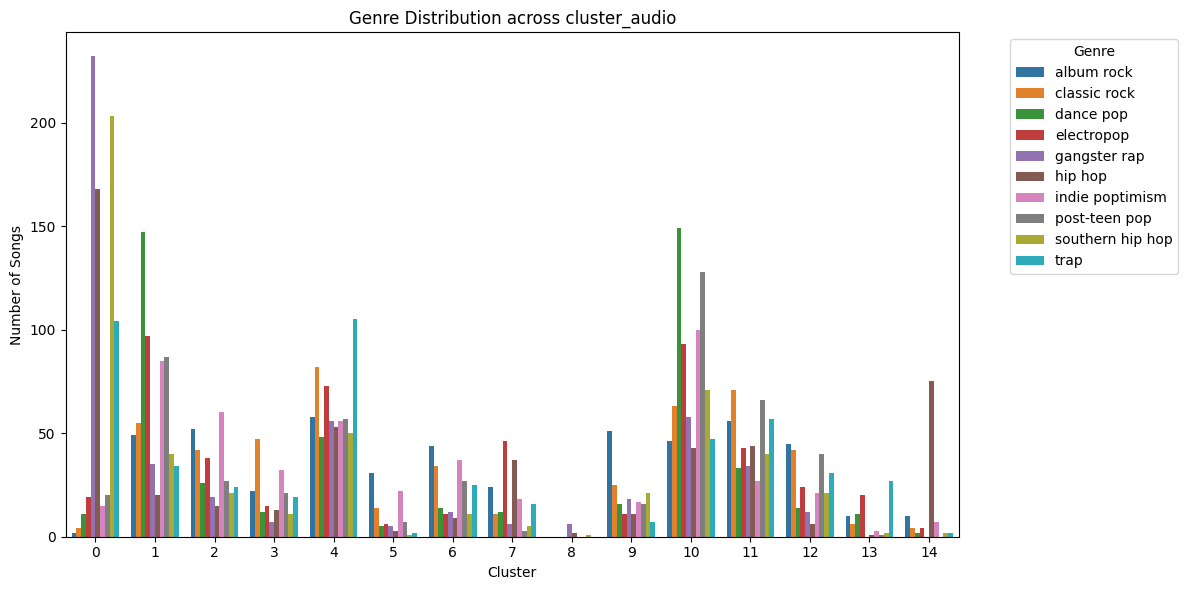

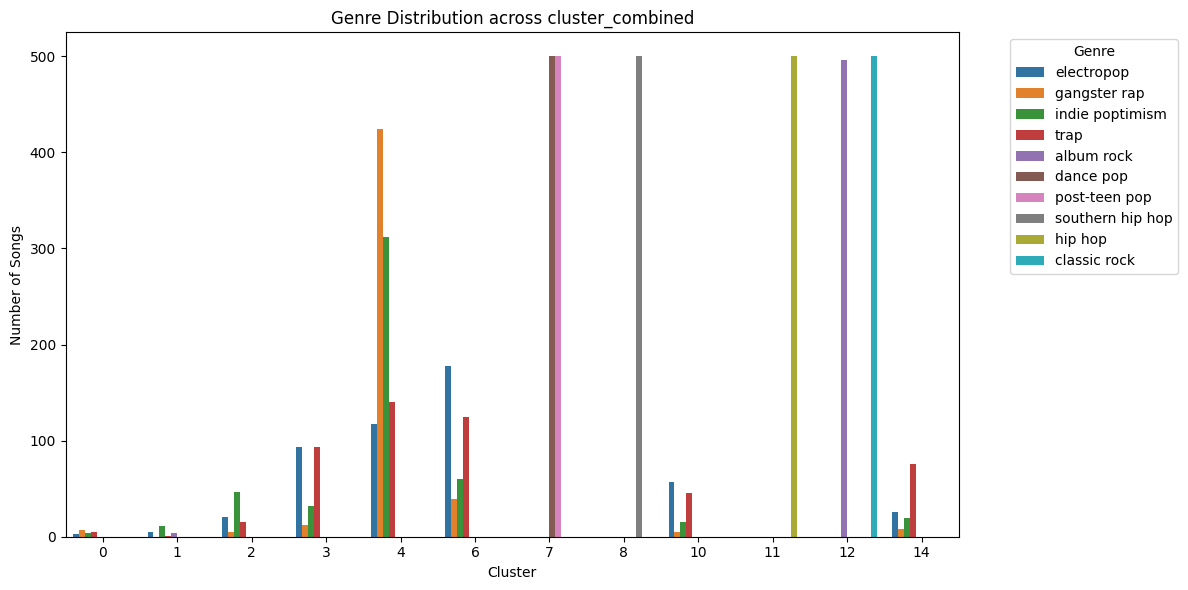

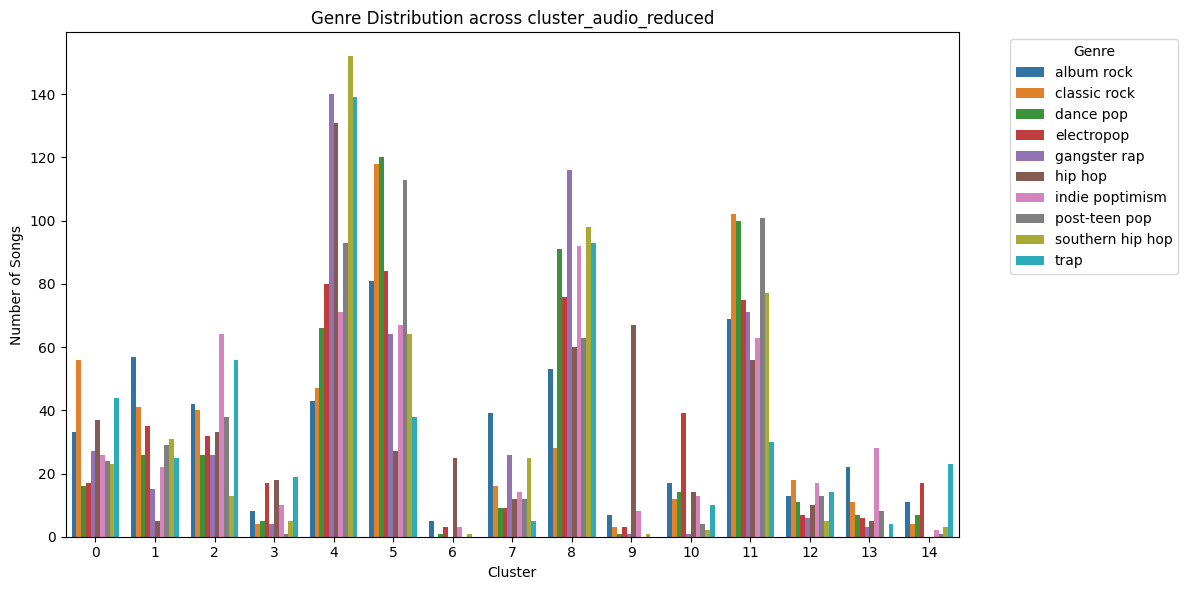

In [558]:
plot_genre_distribution(df, 'cluster_audio')
plot_genre_distribution(df, 'cluster_combined')
plot_genre_distribution(df, 'cluster_audio_reduced')

Genre heatmap

In [559]:
"""def plot_genre_heatmap(df, cluster_col):

    genre = df['final_genre'].fillna('').str.lower()
    genre_dummies = pd.get_dummies(genre)
    genre_dummies[cluster_col] = df[cluster_col].values
    genre_cluster = genre_dummies.groupby(cluster_col).sum()

    plt.figure(figsize=(40, 40))
    sns.heatmap(genre_cluster, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Genres per {cluster_col}")
    plt.xlabel("Genre")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()"""

def plot_genre_heatmap(df, cluster_col, top_n=10):
    # Standardize genre names
    genre = df['final_genre'].fillna('').str.lower()

    # One-hot encode genres
    genre_dummies = pd.get_dummies(genre)
    genre_dummies[cluster_col] = df[cluster_col].values

    # Group by cluster
    genre_cluster = genre_dummies.groupby(cluster_col).sum()

    # Get top N genres by total count across all clusters
    top_genres = genre_cluster.sum().sort_values(ascending=False).head(top_n).index
    genre_cluster_top = genre_cluster[top_genres]

    # Plot
    plt.figure(figsize=(2 * top_n, 8))  # adjust width depending on number of genres
    sns.heatmap(genre_cluster_top, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Top {top_n} Genres per {cluster_col}")
    plt.xlabel("Genre")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()

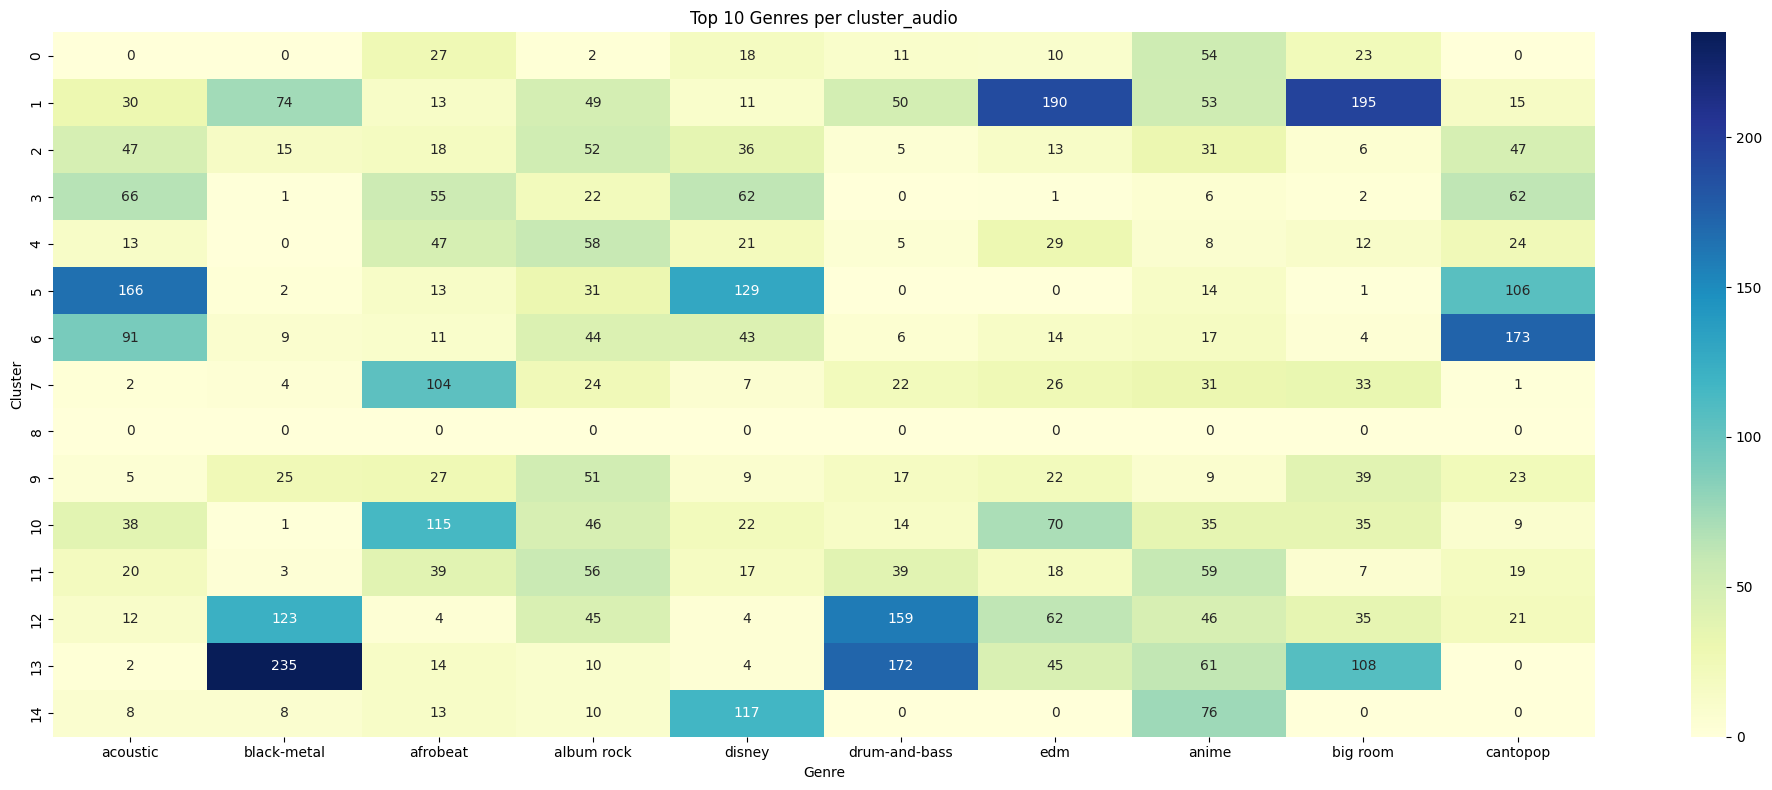

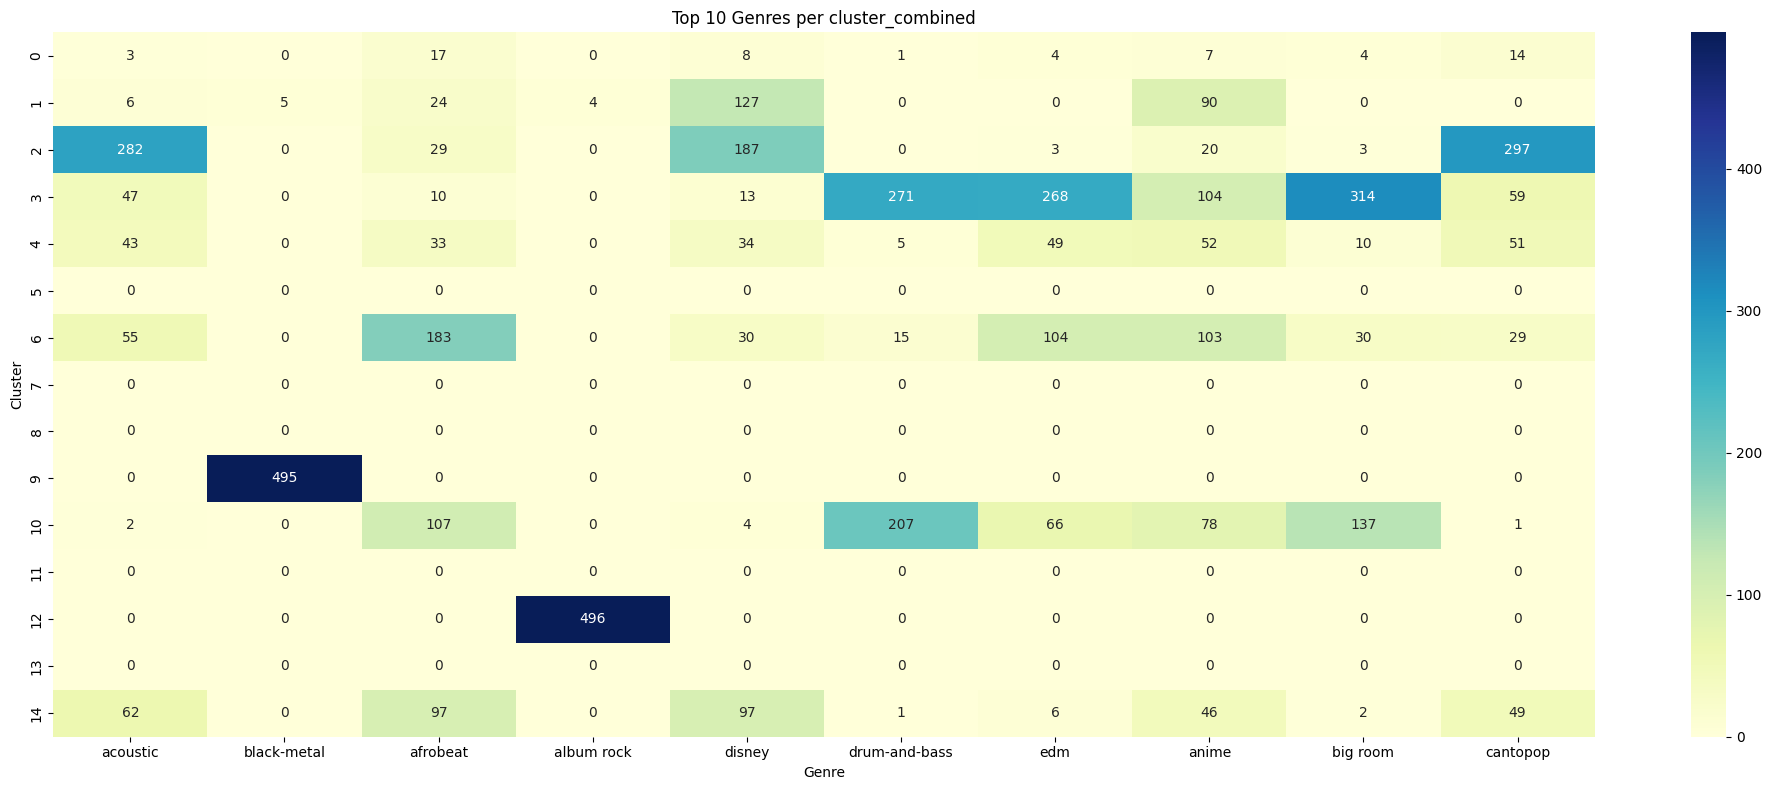

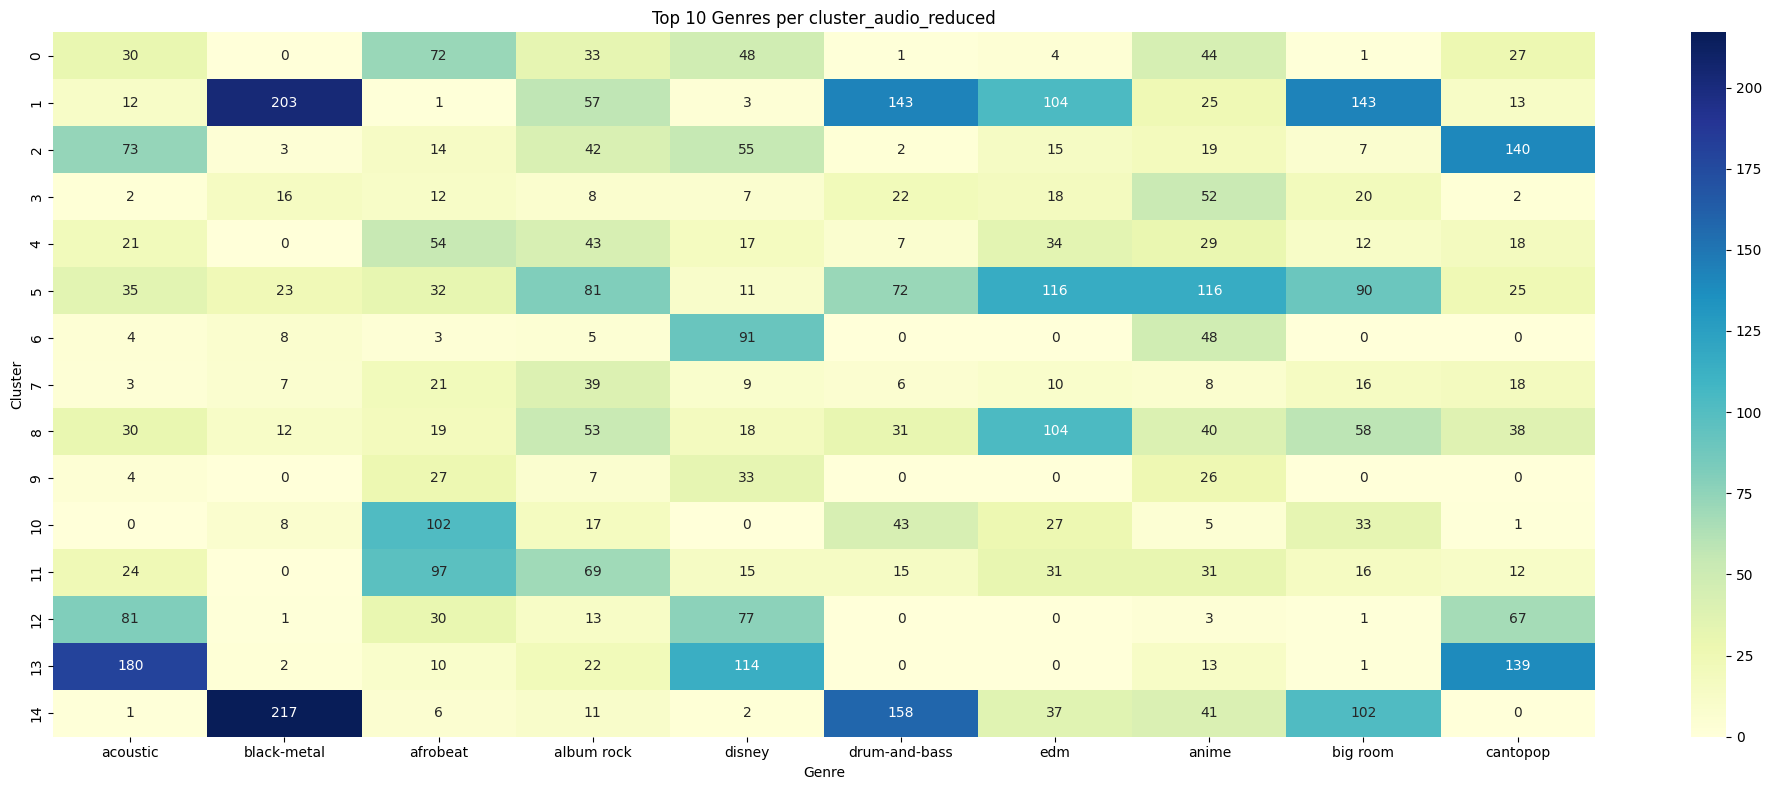

In [560]:
plot_genre_heatmap(df, 'cluster_audio',top_n=10)
plot_genre_heatmap(df, 'cluster_combined',top_n=10)
plot_genre_heatmap(df, 'cluster_audio_reduced',top_n=10)

Evaluate clustering quality

In [561]:
from sklearn.metrics import silhouette_score

# Audio-only
inertia_audio = kmeans_audio.inertia_
silhouette_audio = silhouette_score(X_audio_scaled, df['cluster_audio'])

# Combined
inertia_combined = kmeans_both.inertia_
silhouette_combined = silhouette_score(reduced_combined, df['cluster_combined'])

# Reduced audio features
inertia_reduced = kmeans_audio_reduced.inertia_
silhouette_reduced = silhouette_score(reduced_features, df['cluster_audio_reduced'])

print(f"🎧 Audio-only Clustering:\n - Inertia: {inertia_audio:.2f}\n - Silhouette Score: {silhouette_audio:.3f}")
print(f"🎵 Audio+Genre Clustering:\n - Inertia: {inertia_combined:.2f}\n - Silhouette Score: {silhouette_combined:.3f}")
print(f" Reduced Audio:\n - Inertia: {inertia_reduced:.2f}\n - Silhouette Score: {silhouette_reduced:.3f}")




🎧 Audio-only Clustering:
 - Inertia: 232771.98
 - Silhouette Score: 0.139
🎵 Audio+Genre Clustering:
 - Inertia: 81461.59
 - Silhouette Score: 0.018
 Reduced Audio:
 - Inertia: 5833.46
 - Silhouette Score: 0.182


Cluster centroids

In [562]:

centroids_audio = pd.DataFrame(kmeans_audio.cluster_centers_, columns=audio_features)
centroids_audio.index.name = 'Cluster'
print("🎯 Centroids of Audio-only Clusters:")
display(centroids_audio.round(3))

"""pca_m = reduced_combined.shape[1]
pca_c = [f"PC{i+1}" for i in range(pca_m)]

centroids_audio_combined = pd.DataFrame(kmeans_both.cluster_centers_, columns=audio_features)
centroids_audio_combined.index.name = 'Cluster'
print("🎯 Centroids of Audio combined Clusters:")
display(centroids_audio_combined.round(3))"""

pca_n = reduced_features.shape[1]
pca_cols = [f"PC{i+1}" for i in range(pca_n)]

centroids_audio_reduced = pd.DataFrame(kmeans_audio_reduced.cluster_centers_, columns=pca_cols)
centroids_audio_reduced.index.name = 'Cluster'
print("🎯 Centroids of Audio reduced Clusters:")
display(centroids_audio_reduced.round(3))

🎯 Centroids of Audio-only Clusters:


danceability  energy  valence  normalized_tempo  normalized_loudness  \
Cluster                                                                         
0               0.795  -0.047    0.284            -0.236                0.097   
1              -0.221   0.789   -0.523            -0.272                0.751   
2              -0.461  -0.469   -0.593            -1.157               -0.054   
3               0.428  -0.721    0.849            -0.311               -0.428   
4               0.965  -0.415    0.329            -0.135               -0.491   
5              -0.769  -1.789   -0.721            -0.570               -1.511   
6              -0.578  -0.825   -0.690             0.895               -0.338   
7               0.691   0.126   -0.125             0.095               -0.506   
8              -0.200   0.276   -0.172            -0.708               -0.759   
9              -0.293   0.446    0.119             0.104                0.243   
10              0.783   0.602    1.017            -0.433                0.669   
11              0.088   0.644    1.012             1.211                0.589   
12             -1.086   0.896   -0.625             1.295                0.786   
13             -0.963   0.971   -1.020             0.345                0.383   
14             -0.713  -1.558   -0.906            -0.376               -1.859   

         acousticness  instrumentalness  liveness  speechiness  
Cluster                                                         
0              -0.106            -0.418    -0.150        2.221  
1              -0.734            -0.365    -0.090       -0.203  
2               0.064            -0.390    -0.250       -0.352  
3               1.319            -0.384    -0.188       -0.299  
4              -0.454            -0.377    -0.379       -0.154  
5               1.755            -0.378    -0.207       -0.406  
6               0.623            -0.405    -0.301       -0.389  
7              -0.537             2.323    -0.381       -0.264  
8               1.621            -0.430     2.705        7.319  
9              -0.071            -0.298     2.978       -0.026  
10             -0.409            -0.410    -0.245       -0.177  
11             -0.355            -0.397    -0.135       -0.117  
12             -0.768            -0.351     0.019        0.040  
13             -0.799             2.205     0.110       -0.092  
14              1.534             2.468    -0.300       -0.309

🎯 Centroids of Audio reduced Clusters:


PC1    PC2    PC3    PC4    PC5    PC6
Cluster                                          
0        0.096 -0.323  0.197  0.055 -0.077 -0.039
1       -0.266  0.158 -0.325  0.027 -0.084 -0.026
2        0.254 -0.055 -0.164 -0.080 -0.004  0.002
3        0.045  0.714  0.196 -0.098  0.116  0.052
4       -0.133 -0.154  0.060 -0.143  0.127  0.017
5       -0.314 -0.056 -0.057  0.014 -0.088 -0.007
6        0.830  0.618  0.184  0.061 -0.035 -0.031
7       -0.045 -0.135 -0.140  0.541  0.190  0.054
8       -0.092  0.062 -0.219 -0.164  0.091  0.030
9        0.569  0.363  0.529  0.084 -0.007  0.005
10      -0.202  0.437  0.501  0.034 -0.005  0.008
11      -0.307 -0.243  0.196 -0.018 -0.028 -0.012
12       0.492 -0.302  0.099  0.025 -0.033  0.004
13       0.703 -0.089 -0.209 -0.037 -0.046 -0.003
14      -0.186  0.740  0.065  0.133 -0.060 -0.040

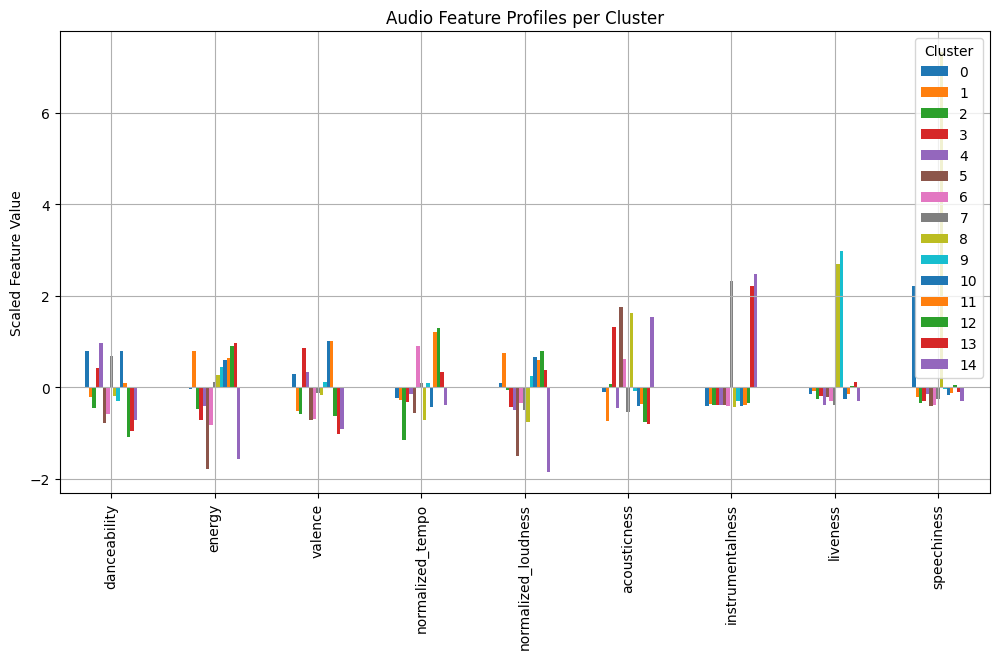

In [563]:
centroids_audio.T.plot(kind='bar', figsize=(12,6), title='Audio Feature Profiles per Cluster')
plt.ylabel('Scaled Feature Value')
plt.grid()
plt.show()


In [564]:
#centroids_audio_combined.T.plot(kind='bar', figsize=(12,6), title='Audio Feature Profiles per Cluster (Audio+genre)')
#plt.ylabel('Scaled Feature Value')
#plt.grid()
#plt.show()

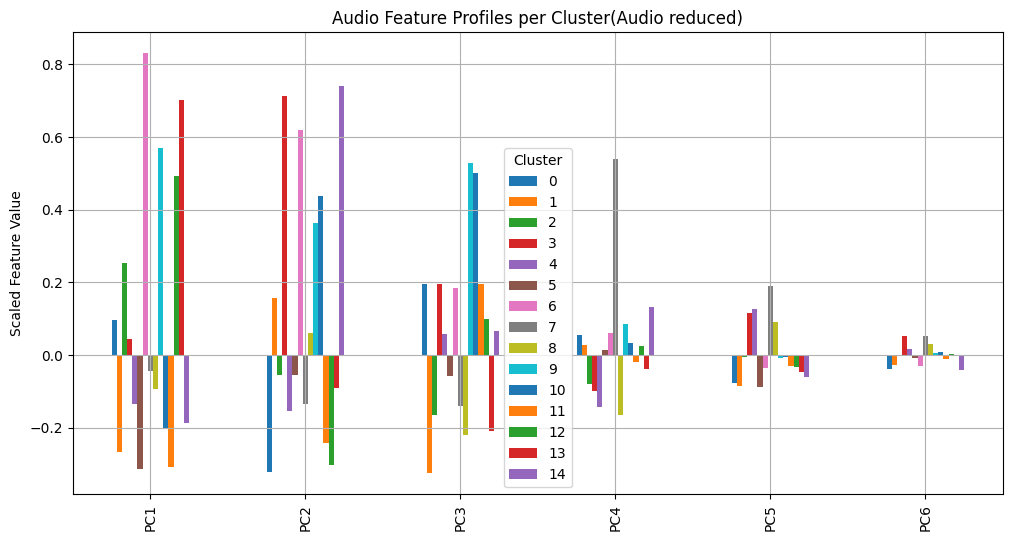

In [565]:
centroids_audio_reduced.T.plot(kind='bar', figsize=(12,6), title='Audio Feature Profiles per Cluster(Audio reduced)')
plt.ylabel('Scaled Feature Value')
plt.grid()
plt.show()

#Identify emotions in clusters

##Get centroids

In [566]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_extreme_songs(X_scaled, kmeans_model, df, cluster_col='cluster_audio',name="", plot=True):
    cluster_labels = kmeans_model.predict(X_scaled)
    records = []

    for i in range(kmeans_model.n_clusters):
        indices = np.where(cluster_labels == i)[0]
        cluster_points = X_scaled[indices]
        centroid = kmeans_model.cluster_centers_[i]
        distances = np.linalg.norm(cluster_points - centroid, axis=1)

        min_idx = indices[np.argmin(distances)]
        max_idx = indices[np.argmax(distances)]

        most = df.iloc[min_idx]
        least = df.iloc[max_idx]

        records.append({
            'Cluster': i,
            'Type': 'Most Representative',
            'final Name': most['track_name'],
            'Artist': most['track_artist'],
            'Genre': most['playlist_genre'],
            'Valence': most['valence'],
            'Energy': most['energy']
        })
        records.append({
            'Cluster': i,
            'Type': 'Least Representative',
            'Track Name': least['track_name'],
            'Artist': least['track_artist'],
            'Genre': least['playlist_genre'],
            'Valence': least['valence'],
            'Energy': least['energy']
        })

    result_df = pd.DataFrame(records)
    print(f"🎶 Most and Least Representative Songs per Cluster for {name}:")
    display(result_df)

    if plot:
        pca = PCA(n_components=2)
        reduced_X = pca.fit_transform(X_scaled)
        reduced_centroids = pca.transform(kmeans_model.cluster_centers_)

        #least_coords = reduced_X[[np.where(cluster_labels == i)[0][np.argmax(
         #   np.linalg.norm(X_scaled[np.where(cluster_labels == i)[0]] - kmeans_model.cluster_centers_[i], axis=1))] for i in range(kmeans_model.n_clusters)]]

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=cluster_labels, palette='Set2')
        plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='black', marker='X', s=100, label='Centroids')
        #plt.scatter(least_coords[:, 0], least_coords[:, 1], c='red', marker='x', s=80, label='Least Rep. Songs')
        plt.title(f'Clusters with Centroids and Least Representative Songs for {name}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.legend()
        #plt.tight_layout()
        plt.show()

    return result_df



🎶 Most and Least Representative Songs per Cluster for Audio only:


Cluster                  Type                            final Name  \
0         0   Most Representative                            Victorious   
1         0  Least Representative                                   NaN   
2         1   Most Representative                                  Holy   
3         1  Least Representative                                   NaN   
4         2   Most Representative                Innayolam Enne Nadathi   
5         2  Least Representative                                   NaN   
6         3   Most Representative                              Tell Her   
7         3  Least Representative                                   NaN   
8         4   Most Representative            Thunderbolts and Lightnin'   
9         4  Least Representative                                   NaN   
10        5   Most Representative                La Voz De Buenos Aires   
11        5  Least Representative                                   NaN   
12        6   Most Representative                      Good News - Live   
13        6  Least Representative                                   NaN   
14        7   Most Representative                               Gravity   
15        7  Least Representative                                   NaN   
16        8   Most Representative          Rock, Paper, Scissors, Jesus   
17        8  Least Representative                                   NaN   
18        9   Most Representative                           Ik Vaari Aa   
19        9  Least Representative                                   NaN   
20       10   Most Representative   I Want You Back (Glee Cast Version)   
21       10  Least Representative                                   NaN   
22       11   Most Representative                              Distance   
23       11  Least Representative                                   NaN   
24       12   Most Representative                               Eternal   
25       12  Least Representative                                   NaN   
26       13   Most Representative  (This Is Our) House (Arcade Version)   
27       13  Least Representative                                   NaN   
28       14   Most Representative            Ojos Negros - Instrumental   
29       14  Least Representative                                   NaN   

                                               Artist        Genre  Valence  \
0                                               E-Dee      j-dance  0.63300   
1                                               jhfly          rap  0.96000   
2                               Hogland;Charlie South   deep-house  0.37700   
3                                           Dubscribe      dubstep  0.15300   
4                                      Elizabeth Raju        malay  0.42400   
5                      Natural White Noise Relaxation        sleep  0.01990   
6                                        James Hunter      british  0.73400   
7                                       Carlos Gardel        tango  0.85200   
8                                         Jayke Orvis         goth  0.54900   
9                           Blake Rules;Netherfriends         kids  0.20300   
10                                    Eladia Blazquez        tango  0.35500   
11                             Dan Gibson's Solitudes      new-age  0.04880   
12                              Bryan & Katie Torwalt  world-music  0.25100   
13                                  Lluvia del Bosque        latin  0.05340   
14                     Monkey Safari;Delhia De France   deep-house  0.46100   
15                                      Paco de Lucía       guitar  0.91900   
16                                       Chad Daniels       comedy  0.43300   
17  Spa;Spa, Relaxation and Dreams;Meditation;Wate...        sleep  0.02140   
18                                Pritam;Arijit Singh       indian  0.42800   
19                               White Noise Research        sleep  0.00001   
20                 

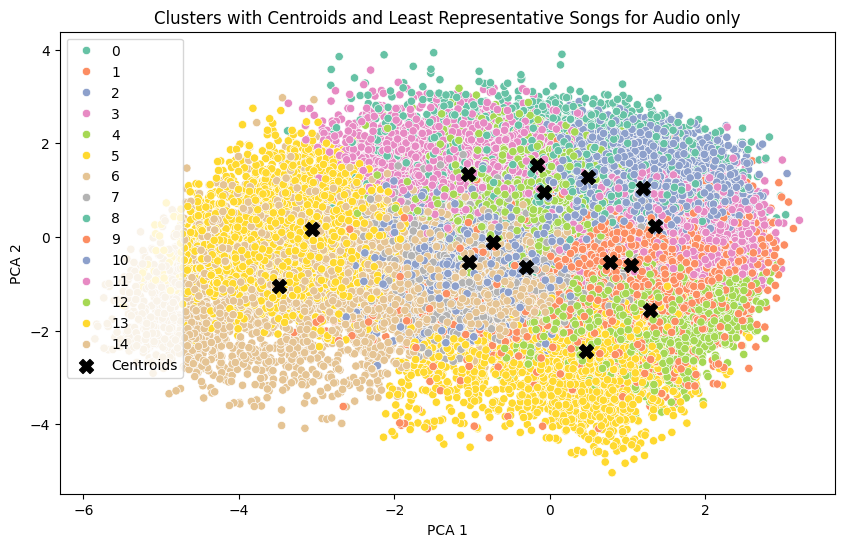

🎶 Most and Least Representative Songs per Cluster for Audio+Genre:


Cluster                  Type                            final Name  \
0         0   Most Representative              Cruz de tecido - Ao vivo   
1         0  Least Representative                                   NaN   
2         1   Most Representative                               Azurite   
3         1  Least Representative                                   NaN   
4         2   Most Representative                    Christmas In April   
5         2  Least Representative                                   NaN   
6         3   Most Representative                               You Are   
7         3  Least Representative                                   NaN   
8         4   Most Representative                             In My Bed   
9         4  Least Representative                                   NaN   
10        5   Most Representative                 A Mansion On the Hill   
11        5  Least Representative                                   NaN   
12        6   Most Representative                            Thong Song   
13        6  Least Representative                                   NaN   
14        7   Most Representative  Kanja Poovu Kannala (From "Viruman")   
15        7  Least Representative                                   NaN   
16        8   Most Representative                                  1994   
17        8  Least Representative                                   NaN   
18        9   Most Representative     Mary On A Cross - slowed + reverb   
19        9  Least Representative                                   NaN   
20       10   Most Representative            All I Want (feat. Goatchy)   
21       10  Least Representative                                   NaN   
22       11   Most Representative                                 VOGUE   
23       11  Least Representative                                   NaN   
24       12   Most Representative                               Answers   
25       12  Least Representative                                   NaN   
26       13   Most Representative        Rather Be - The Magician Remix   
27       13  Least Representative                                   NaN   
28       14   Most Representative              Secret (feat. YK Osiris)   
29       14  Least Representative                                   NaN   

                                   Artist          Genre  Valence  Energy  \
0                                 O Rappa            r&b   0.4290   0.793   
1                           Serial Killaz  drum-and-bass   0.6870   0.960   
2             Sarah, the Illstrumentalist          study   0.3200   0.402   
3                  Dan Gibson's Solitudes        new-age   0.0488   0.239   
4                             Andrew Bird            r&b   0.3010   0.304   
5                           Janet Jackson            r&b   0.3780   0.188   
6                          Charlie Wilson            r&b   0.2420   0.824   
7                        Roni Size;DJ Suv  drum-and-bass   0.7110   0.968   
8                                  Rotimi            r&b   0.4310   0.501   
9                           Color Me Badd            r&b   0.9410   0.885   
10                      Stonewall Jackson     honky-tonk   0.5330   0.354   
11                              Mrs Mills     honky-tonk   0.9600   0.678   
12                                  Sisqo            r&b   0.7140   0.888   
13                     Ed Solo;Stickybuds  drum-and-bass   0.9180   0.910   
14          Yuvan Shankar Raja;Sid Sriram            pop   0.5200   0.692   
15                        Jacques Renault            pop   0.9170   0.731   
16                              Quasimoto            rap   0.5970   0.675   
17        DJ Screw & The Screwed Up Click            rap   0.7730   0.841   
18                                  Ghost          metal   0.2590   0.838   
19                         Anaal Nathrakh    black-metal   0.0781   0.613   
20                  Tube & Berger;Goatchy         techno   0.

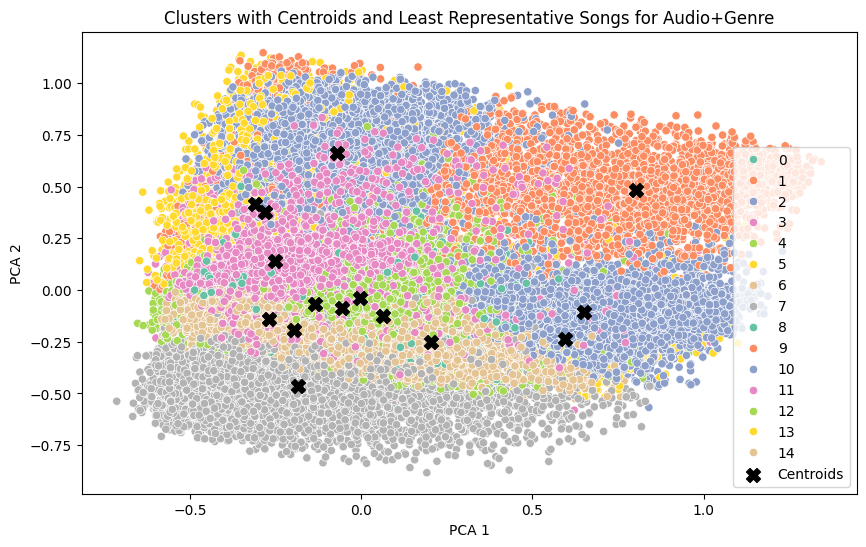

🎶 Most and Least Representative Songs per Cluster for Audio reduced:


Cluster                  Type  \
0         0   Most Representative   
1         0  Least Representative   
2         1   Most Representative   
3         1  Least Representative   
4         2   Most Representative   
5         2  Least Representative   
6         3   Most Representative   
7         3  Least Representative   
8         4   Most Representative   
9         4  Least Representative   
10        5   Most Representative   
11        5  Least Representative   
12        6   Most Representative   
13        6  Least Representative   
14        7   Most Representative   
15        7  Least Representative   
16        8   Most Representative   
17        8  Least Representative   
18        9   Most Representative   
19        9  Least Representative   
20       10   Most Representative   
21       10  Least Representative   
22       11   Most Representative   
23       11  Least Representative   
24       12   Most Representative   
25       12  Least Representative   
26       13   Most Representative   
27       13  Least Representative   
28       14   Most Representative   
29       14  Least Representative   

                                           final Name  \
0                                              Ayonha   
1                                                 NaN   
2                              Mad World - Radio Edit   
3                                                 NaN   
4                                        Tattım Ölümü   
5                                                 NaN   
6                             Svanur (feat. Rökkurró)   
7                                                 NaN   
8                                  Saw You in a Dream   
9                                                 NaN   
10                                      Randall Flagg   
11                                                NaN   
12                                        Hydrosphere   
13                                                NaN   
14                           Mundo Paralelo - Ao Vivo   
15                                                NaN   
16                                      Breaking Free   
17                                                NaN   
18  If You're Happy and You Know it Clap Your Hand...   
19                                                NaN   
20                       Music's In Me - Original Mix   
21                                                NaN   
22                         Superheld (Austrian Style)   
23                                                NaN   
24                  El Último Verano - Balada Moderna   
25                                                NaN   
26                                        Copulations   
27                                                NaN   
28       Waves (Tomorrowland 2014 Anthem) - Radio Mix   
29                                                NaN   

                                               Artist          Genre  Valence  \
0                                     Hamid Al Shaeri         groove  0.72900   
1                                             Stormzy            rap  0.95000   
2                                            Hardwell            edm  0.25300   
3                                           Pearl Jam         grunge  0.06000   
4                                    Ahmet Can Dündar        turkish  0.32200   
5       White Noise Baby Sleep;White Noise for Babies          sleep  0.00000   
6                                      Fejká;Rökkurró        ambient  0.27700   
7                                      Lobby Lingu!n!          study  0.25600   
8                                  The Japanese House           soul  0.68300   
9                                              Afluen            rap  0.64800   
10                                         Surf Curse           punk  0.63700   
11                                       Jimi Hendrix     psych-rock  0.44800   
12                                 

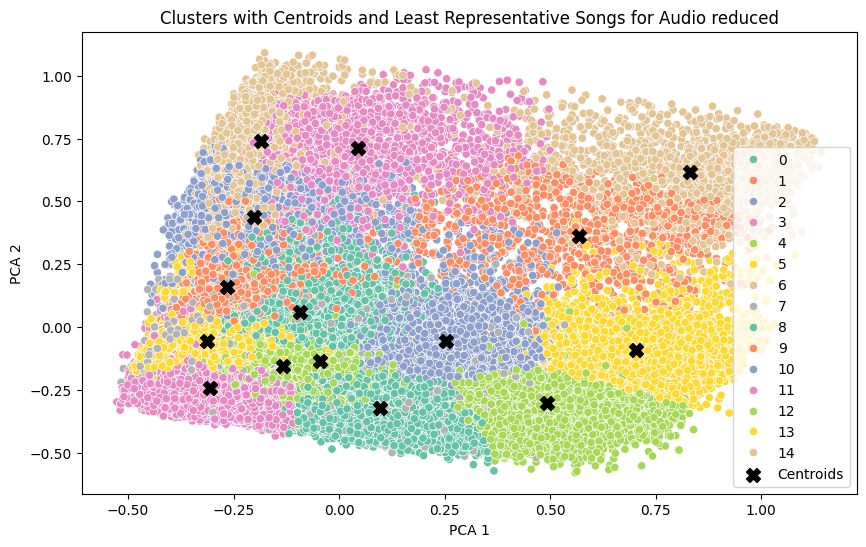

In [567]:
result_audio=analyze_extreme_songs(X_audio_scaled, kmeans_audio, df, cluster_col='cluster_audio',name="Audio only",plot=True)
result_audio_combined=analyze_extreme_songs(X_combined.toarray(), kmeans_both, df, cluster_col='cluster_combined',name="Audio+Genre",plot=True)
result_audio_reduced=analyze_extreme_songs(reduced_features, kmeans_audio_reduced, df, cluster_col='cluster_audio_reduced',name="Audio reduced",plot=True)

#Identify average clusters features

##Clusters stats

In [568]:
def summarize_clusters(df, cluster_col="cluster", features=None):
    if features is None:
        # Default to common audio features
        features = [
            "acousticness", "danceability", "energy",
            "instrumentalness", "liveness", "speechiness",
            "valence", "normalized_loudness", "normalized_tempo"
        ]

    grouped = df.groupby(cluster_col)

    summary_mean = grouped[features].mean().add_suffix("_mean")
    summary_std = grouped[features].std().add_suffix("_std")
    summary_median = grouped[features].median().add_suffix("_median")

    # Combine all summaries into one DataFrame
    summary = pd.concat([summary_mean, summary_std, summary_median], axis=1)
    summary.index.name = cluster_col

    return summary.reset_index()


In [569]:
summary_stats = summarize_clusters(df, 'cluster_audio', audio_features)
display(summary_stats.head())

summary_stats_combined = summarize_clusters(df,'cluster_combined',audio_features)
display(summary_stats_combined.head())


summary_stats_reduced = summarize_clusters(df,'cluster_audio_reduced',audio_features)
display(summary_stats_reduced.head())

cluster_audio  danceability_mean  energy_mean  valence_mean  \
0              0           0.729955     0.653792      0.563122   
1              1           0.561786     0.838274      0.359541   
2              2           0.521943     0.560652      0.341765   
3              3           0.669262     0.505520      0.705783   
4              4           0.757999     0.572637      0.574087   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.390184                  0.880653           0.243491   
1               0.385332                  0.917618           0.051908   
2               0.263969                  0.872074           0.295002   
3               0.379681                  0.850960           0.677752   
4               0.404270                  0.847372           0.137310   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.013781       0.181759          0.330143  ...   
1               0.029042       0.192749          0.069353  ...   
2               0.021871       0.163513          0.053291  ...   
3               0.023413       0.174902          0.059110  ...   
4               0.025655       0.139674          0.074615  ...   

   speechiness_std  danceability_median  energy_median  valence_median  \
0         0.084605                0.740          0.659           0.574   
1         0.045862                0.569          0.850           0.363   
2         0.042407                0.534          0.563           0.333   
3         0.044728                0.672          0.502           0.713   
4         0.049403                0.763          0.575           0.568   

   normalized_tempo_median  normalized_loudness_median  acousticness_median  \
0                 0.353068                    0.884958               0.1760   
1                 0.405342                    0.918700               0.0120   
2                 0.258937                    0.876583               0.2650   
3                 0.378908                    0.854433               0.6860   
4                 0.420468                    0.854117               0.0983   

   instrumentalness_median  liveness_median  speechiness_median  
0                 0.000000            0.129              0.3160  
1                 0.000045            0.152              0.0527  
2                 0.000003            0.122              0.0366  
3                 0.000003            0.131              0.0420  
4                 0.000034            0.109              0.0548  

[5 rows x 28 columns]

cluster_combined  danceability_mean  energy_mean  valence_mean  \
0                 0           0.547795     0.742251      0.538755   
1                 1           0.497417     0.342448      0.292094   
2                 2           0.493188     0.334823      0.324432   
3                 3           0.495444     0.815228      0.320774   
4                 4           0.670760     0.599302      0.425069   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.407964                  0.875788           0.446457   
1               0.371553                  0.778432           0.737201   
2               0.384777                  0.816260           0.767312   
3               0.518503                  0.912129           0.064149   
4               0.331869                  0.871132           0.167639   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.009851       0.789096          0.233240  ...   
1               0.830972       0.160901          0.061065  ...   
2               0.020255       0.168617          0.055668  ...   
3               0.038767       0.222434          0.089853  ...   
4               0.017105       0.164927          0.115818  ...   

   speechiness_std  danceability_median  energy_median  valence_median  \
0         0.312621               0.5550          0.755          0.5480   
1         0.060755               0.5205          0.319          0.2275   
2         0.067369               0.4990          0.332          0.3050   
3         0.081826               0.4990          0.851          0.3160   
4         0.113537               0.6830          0.597          0.4160   

   normalized_tempo_median  normalized_loudness_median  acousticness_median  \
0                 0.397311                    0.885217                0.452   
1                 0.358739                    0.773458                0.812   
2                 0.383821                    0.820217                0.800   
3                 0.526247                    0.915417                0.014   
4                 0.315589                    0.876917                0.134   

   instrumentalness_median  liveness_median  speechiness_median  
0                 0.000000            0.805              0.0717  
1                 0.878000            0.112              0.0416  
2                 0.000010            0.118              0.0364  
3                 0.000062            0.162              0.0585  
4                 0.000002            0.119              0.0606  

[5 rows x 28 columns]

cluster_audio_reduced  danceability_mean  energy_mean  valence_mean  \
0                      0           0.677156     0.680951      0.788250   
1                      1           0.431678     0.875192      0.242491   
2                      2           0.557963     0.513239      0.334267   
3                      3           0.644438     0.592973      0.208510   
4                      4           0.760777     0.616112      0.601523   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.416809                  0.882025           0.508255   
1               0.478521                  0.916039           0.027693   
2               0.403451                  0.860382           0.461461   
3               0.425687                  0.831037           0.105676   
4               0.372178                  0.876009           0.136029   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.008642       0.183679          0.096605  ...   
1               0.040359       0.242210          0.095345  ...   
2               0.015351       0.156176          0.073714  ...   
3               0.805225       0.137087          0.060733  ...   
4               0.011999       0.147278          0.129028  ...   

   speechiness_std  danceability_median  energy_median  valence_median  \
0         0.103628               0.6820          0.684          0.8000   
1         0.076899               0.4405          0.904          0.2450   
2         0.091086               0.5610          0.514          0.3395   
3         0.048066               0.6800          0.598          0.1900   
4         0.113663               0.7680          0.623          0.5930   

   normalized_tempo_median  normalized_loudness_median  acousticness_median  \
0                 0.396021                    0.887550              0.49200   
1                 0.473782                    0.920392              0.00357   
2                 0.408747                    0.866583              0.45900   
3                 0.442016                    0.834750              0.03640   
4                 0.352984                    0.883617              0.11700   

   instrumentalness_median  liveness_median  speechiness_median  
0                 0.000000            0.139              0.0504  
1                 0.000486            0.201              0.0694  
2                 0.000002            0.119              0.0379  
3                 0.852000            0.108              0.0461  
4                 0.000002            0.112              0.0790  

[5 rows x 28 columns]

##Circumplex of Affect by Russell for emotion classification

In [570]:
import matplotlib.pyplot as plt

def plot_emotion_circumplex(summary_stats, cluster_col='cluster_audio',name="",legend=""):
    plt.figure(figsize=(8, 8))

    # Scatter plot for each cluster
    for _, row in summary_stats.iterrows():
        plt.scatter(row['valence_mean'], row['energy_mean'], s=150)
        plt.text(row['valence_mean'] + 0.01, row['energy_mean'] + 0.01,
                 f"Cluster {int(row[cluster_col])}", fontsize=12)

    # Plot axes and emotion labels
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.axvline(0.5, color='gray', linestyle='--')

    plt.text(0.8, 0.9, "Excited / Happy", fontsize=12, color='green')
    plt.text(0.1, 0.9, "Tense / Angry", fontsize=12, color='red')
    plt.text(0.1, 0.1, "Sad / Depressed", fontsize=12, color='blue')
    plt.text(0.75, 0.1, "Calm / Relaxed", fontsize=12, color='purple')

    plt.xlabel("Valence (Pleasantness)")
    plt.ylabel(f"Arousal {legend}")
    plt.title(f"Emotion Circumplex of Russell for Clusters from {name}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


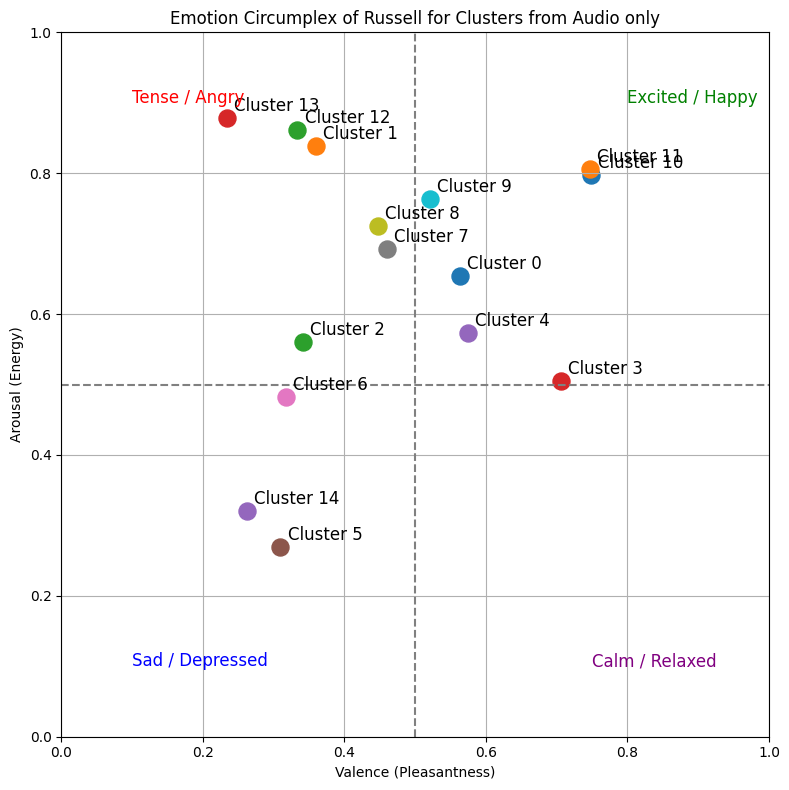

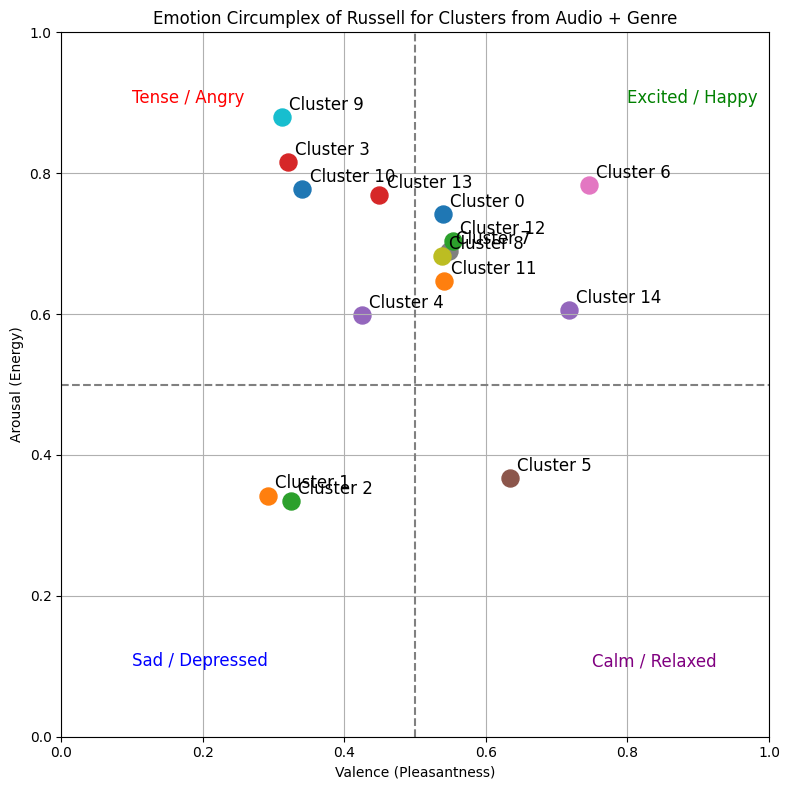

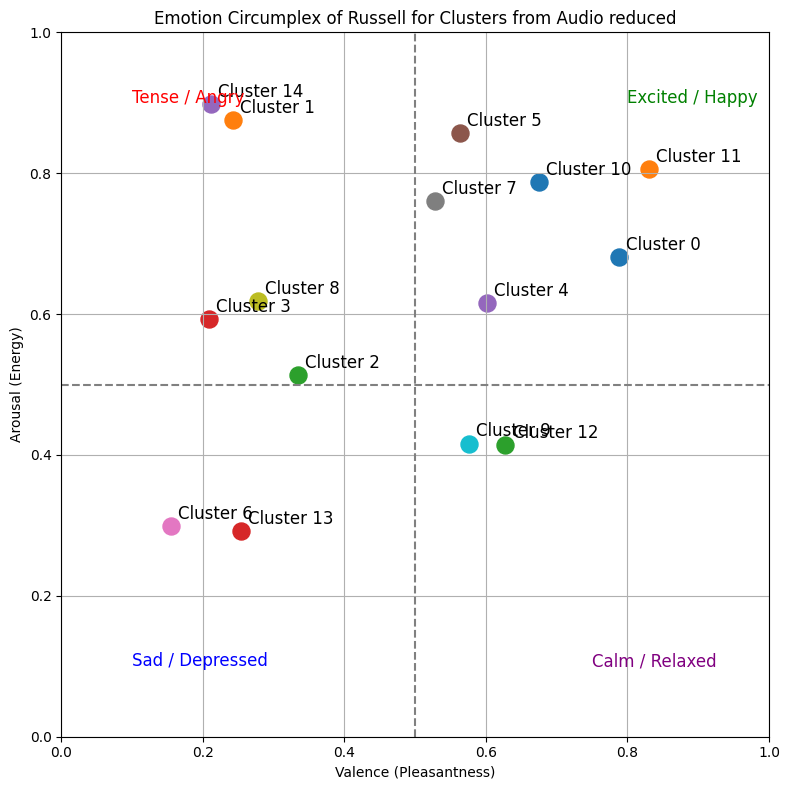

In [571]:
plot_emotion_circumplex(summary_stats, 'cluster_audio',name="Audio only",legend="(Energy)")

plot_emotion_circumplex(summary_stats_combined, 'cluster_combined',name="Audio + Genre",legend="(Energy)")

plot_emotion_circumplex(summary_stats_reduced, 'cluster_audio_reduced',name="Audio reduced",legend="(Energy)")


##Compute Arousal

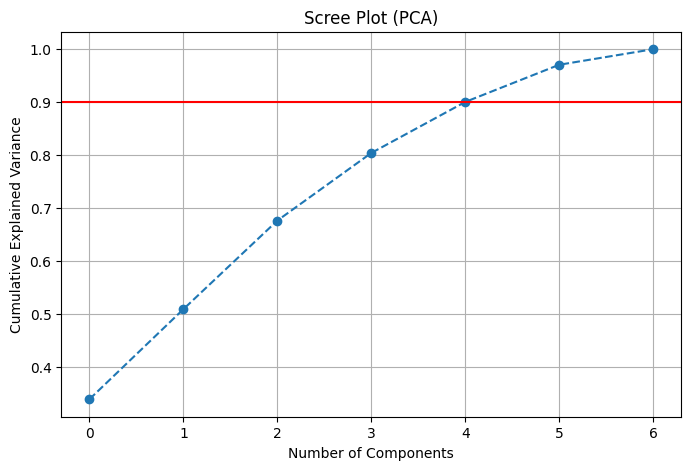

Optimal n=5


In [572]:
features_for_pca = [
    'energy', 'normalized_tempo', 'normalized_loudness',
    'danceability', 'speechiness', 'liveness', 'acousticness'
]

scaler = StandardScaler()
X_arousal = scaler.fit_transform(df[features_for_pca])

pca = PCA()
pca.fit(X_arousal)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Scree Plot

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot (PCA)')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-')  # Mark the 90% threshold
plt.show()

threshold = 0.90
optimal_n = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1
print(f"Optimal n={optimal_n}")

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_arousal)

df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

components_df = pd.DataFrame(
    pca.components_[:5],  # Only top 5 components
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(5)]
)

print(components_df.T)

In [573]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_arousal)

df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

components_df = pd.DataFrame(
    pca.components_[:5],  # Only top 5 components
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(5)]
)

print(components_df.T)

                          PC1       PC2       PC3       PC4       PC5
energy               0.599082  0.061856  0.007250 -0.115503 -0.087961
normalized_tempo     0.205437  0.219825 -0.360841  0.865933  0.163865
normalized_loudness  0.546612 -0.055142 -0.013986 -0.156965 -0.065553
danceability         0.077367 -0.675138  0.387135  0.204500  0.580274
speechiness          0.081076  0.094276  0.754577  0.369981 -0.518188
liveness             0.109535  0.675302  0.373451 -0.154013  0.596016
acousticness        -0.524933  0.155172  0.104021  0.098770  0.025339


In [594]:
def summarize_clusters_with_arousal(df, cluster_col="cluster", features=None):
    if features is None:
        features = [
            "acousticness", "danceability", "energy",
            "instrumentalness", "liveness", "speechiness",
            "valence", "normalized_loudness", "normalized_tempo"
        ]

    #Use PC1 as weights to compute an arousal proxy
    df = df.copy()

    df["arousal_raw"] = (
    0.599082 * df["energy"] +
    0.205437 * df["normalized_tempo"] +
    0.546612 * df["normalized_loudness"] +
    0.077367 * df["danceability"] +
    0.081076 * df["speechiness"] +
    0.109535 * df["liveness"] +
   -0.524933 * df["acousticness"]
    )

    #Normalizing the arousal
    scaler = MinMaxScaler()
    df["arousal"] = scaler.fit_transform(df[["arousal_raw"]])

    grouped = df.groupby(cluster_col)

    summary_mean = grouped[features].mean().add_suffix("_mean")
    summary_std = grouped[features].std().add_suffix("_std")
    summary_median = grouped[features].median().add_suffix("_median")

    arousal_mean = grouped["arousal"].mean().rename("arousal_mean")
    arousal_std = grouped["arousal"].std().rename("arousal_std")
    arousal_median = grouped["arousal"].median().rename("arousal_median")

    summary = pd.concat(
        [summary_mean, summary_std, summary_median, arousal_mean, arousal_std, arousal_median],
        axis=1
    )
    summary.index.name = cluster_col

    return summary.reset_index()


def plot_emotion_circumplex_with_arousal(summary_stats, cluster_col='cluster_audio',name="",legend=""):
    plt.figure(figsize=(8, 8))

    # Scatter plot for each cluster
    for _, row in summary_stats.iterrows():
        plt.scatter(row['valence_mean'], row['arousal_mean'], s=150)
        plt.text(row['valence_mean'] + 0.01, row['arousal_mean'] + 0.01,
                 f"Cluster {int(row[cluster_col])}", fontsize=12)

    # Plot axes and emotion labels
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.axvline(0.5, color='gray', linestyle='--')

    plt.text(0.8, 0.9, "Excited / Happy", fontsize=12, color='green')
    plt.text(0.1, 0.9, "Tense / Angry", fontsize=12, color='red')
    plt.text(0.1, 0.1, "Sad / Depressed", fontsize=12, color='blue')
    plt.text(0.75, 0.1, "Calm / Relaxed", fontsize=12, color='purple')

    plt.xlabel("Valence (Pleasantness)")
    plt.ylabel(f"Arousal {legend}")
    plt.title(f"Emotion Circumplex of Russell for Clusters from {name}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [595]:
summary_stats_with_arousal = summarize_clusters_with_arousal(df, 'cluster_audio', audio_features)
display(summary_stats_with_arousal.head())

summary_stats_combined_with_arousal = summarize_clusters_with_arousal(df,'cluster_combined',audio_features)
display(summary_stats_combined_with_arousal.head())


summary_stats_reduced_with_arousal = summarize_clusters_with_arousal(df,'cluster_audio_reduced',audio_features)
display(summary_stats_reduced_with_arousal.head())

cluster_audio  danceability_mean  energy_mean  valence_mean  \
0              0           0.729955     0.653792      0.563122   
1              1           0.561786     0.838274      0.359541   
2              2           0.521943     0.560652      0.341765   
3              3           0.669262     0.505520      0.705783   
4              4           0.757999     0.572637      0.574087   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.390184                  0.880653           0.243491   
1               0.385332                  0.917618           0.051908   
2               0.263969                  0.872074           0.295002   
3               0.379681                  0.850960           0.677752   
4               0.404270                  0.847372           0.137310   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.013781       0.181759          0.330143  ...   
1               0.029042       0.192749          0.069353  ...   
2               0.021871       0.163513          0.053291  ...   
3               0.023413       0.174902          0.059110  ...   
4               0.025655       0.139674          0.074615  ...   

   valence_median  normalized_tempo_median  normalized_loudness_median  \
0           0.574                 0.353068                    0.884958   
1           0.363                 0.405342                    0.918700   
2           0.333                 0.258937                    0.876583   
3           0.713                 0.378908                    0.854433   
4           0.568                 0.420468                    0.854117   

   acousticness_median  instrumentalness_median  liveness_median  \
0               0.1760                 0.000000            0.129   
1               0.0120                 0.000045            0.152   
2               0.2650                 0.000003            0.122   
3               0.6860                 0.000003            0.131   
4               0.0983                 0.000034            0.109   

   speechiness_median  arousal_mean  arousal_std  arousal_median  
0              0.3160      0.661740     0.123682        0.676196  
1              0.0527      0.796705     0.061930        0.803033  
2              0.0366      0.556423     0.102220        0.567200  
3              0.0420      0.413762     0.093350        0.419576  
4              0.0548      0.640309     0.076251        0.646178  

[5 rows x 31 columns]

cluster_combined  danceability_mean  energy_mean  valence_mean  \
0                 0           0.547795     0.742251      0.538755   
1                 1           0.497417     0.342448      0.292094   
2                 2           0.493188     0.334823      0.324432   
3                 3           0.495444     0.815228      0.320774   
4                 4           0.670760     0.599302      0.425069   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.407964                  0.875788           0.446457   
1               0.371553                  0.778432           0.737201   
2               0.384777                  0.816260           0.767312   
3               0.518503                  0.912129           0.064149   
4               0.331869                  0.871132           0.167639   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.009851       0.789096          0.233240  ...   
1               0.830972       0.160901          0.061065  ...   
2               0.020255       0.168617          0.055668  ...   
3               0.038767       0.222434          0.089853  ...   
4               0.017105       0.164927          0.115818  ...   

   valence_median  normalized_tempo_median  normalized_loudness_median  \
0          0.5480                 0.397311                    0.885217   
1          0.2275                 0.358739                    0.773458   
2          0.3050                 0.383821                    0.820217   
3          0.3160                 0.526247                    0.915417   
4          0.4160                 0.315589                    0.876917   

   acousticness_median  instrumentalness_median  liveness_median  \
0                0.452                 0.000000            0.805   
1                0.812                 0.878000            0.112   
2                0.800                 0.000010            0.118   
3                0.014                 0.000062            0.162   
4                0.134                 0.000002            0.119   

   speechiness_median  arousal_mean  arousal_std  arousal_median  
0              0.0717      0.656282     0.147364        0.648148  
1              0.0416      0.287319     0.141181        0.274964  
2              0.0364      0.289440     0.108945        0.288734  
3              0.0585      0.799376     0.091556        0.818490  
4              0.0606      0.638616     0.092863        0.642748  

[5 rows x 31 columns]

cluster_audio_reduced  danceability_mean  energy_mean  valence_mean  \
0                      0           0.677156     0.680951      0.788250   
1                      1           0.431678     0.875192      0.242491   
2                      2           0.557963     0.513239      0.334267   
3                      3           0.644438     0.592973      0.208510   
4                      4           0.760777     0.616112      0.601523   

   normalized_tempo_mean  normalized_loudness_mean  acousticness_mean  \
0               0.416809                  0.882025           0.508255   
1               0.478521                  0.916039           0.027693   
2               0.403451                  0.860382           0.461461   
3               0.425687                  0.831037           0.105676   
4               0.372178                  0.876009           0.136029   

   instrumentalness_mean  liveness_mean  speechiness_mean  ...  \
0               0.008642       0.183679          0.096605  ...   
1               0.040359       0.242210          0.095345  ...   
2               0.015351       0.156176          0.073714  ...   
3               0.805225       0.137087          0.060733  ...   
4               0.011999       0.147278          0.129028  ...   

   valence_median  normalized_tempo_median  normalized_loudness_median  \
0          0.8000                 0.396021                    0.887550   
1          0.2450                 0.473782                    0.920392   
2          0.3395                 0.408747                    0.866583   
3          0.1900                 0.442016                    0.834750   
4          0.5930                 0.352984                    0.883617   

   acousticness_median  instrumentalness_median  liveness_median  \
0              0.49200                 0.000000            0.139   
1              0.00357                 0.000486            0.201   
2              0.45900                 0.000002            0.119   
3              0.03640                 0.852000            0.108   
4              0.11700                 0.000002            0.112   

   speechiness_median  arousal_mean  arousal_std  arousal_median  
0              0.0504      0.566471     0.077645        0.567807  
1              0.0694      0.831288     0.063362        0.841307  
2              0.0379      0.494954     0.075162        0.494204  
3              0.0461      0.649928     0.110555        0.657649  
4              0.0790      0.668511     0.074127        0.674850  

[5 rows x 31 columns]

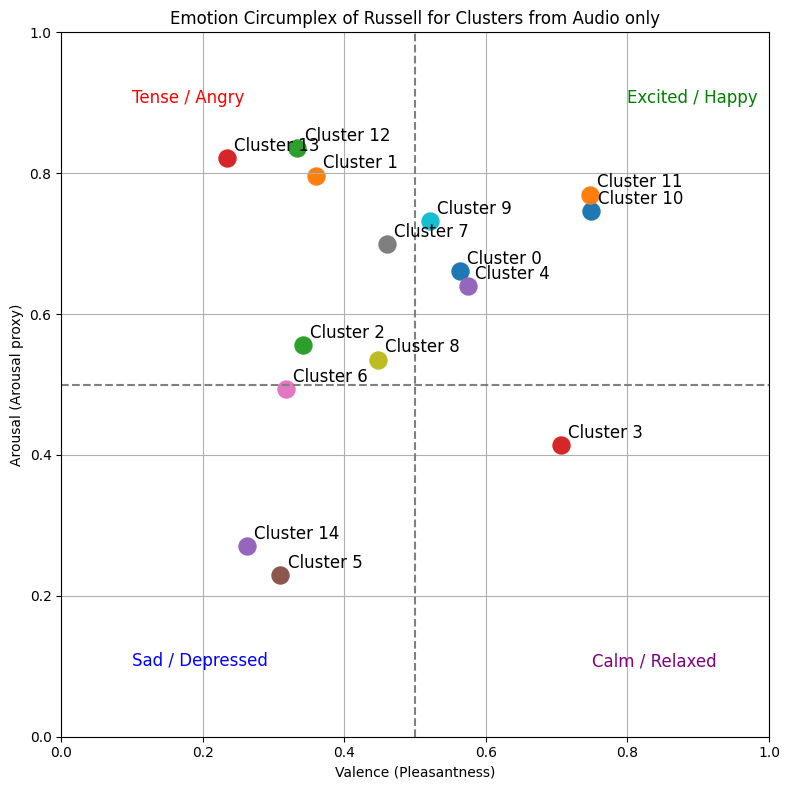

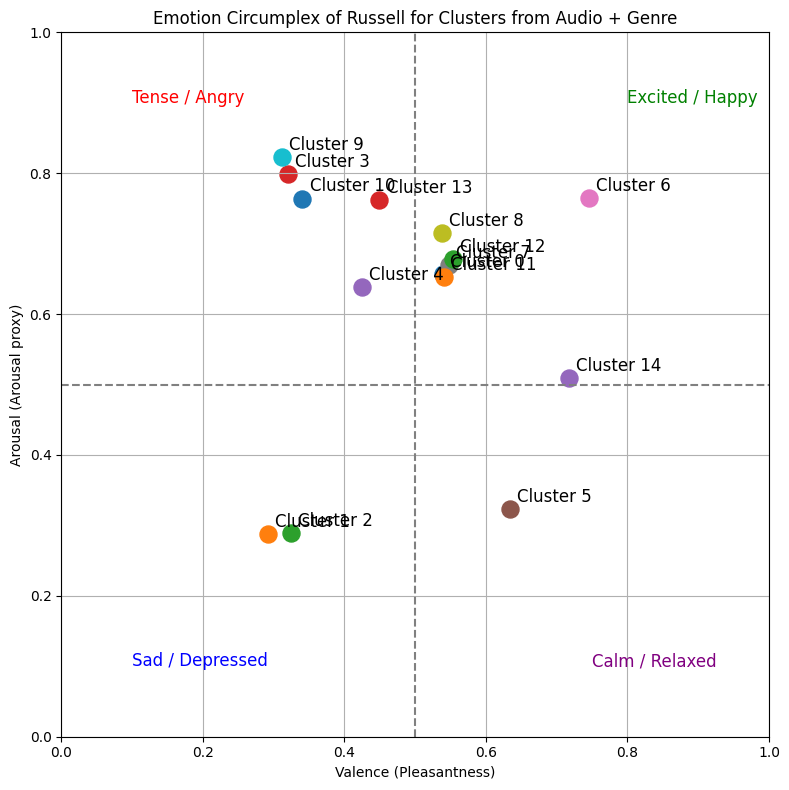

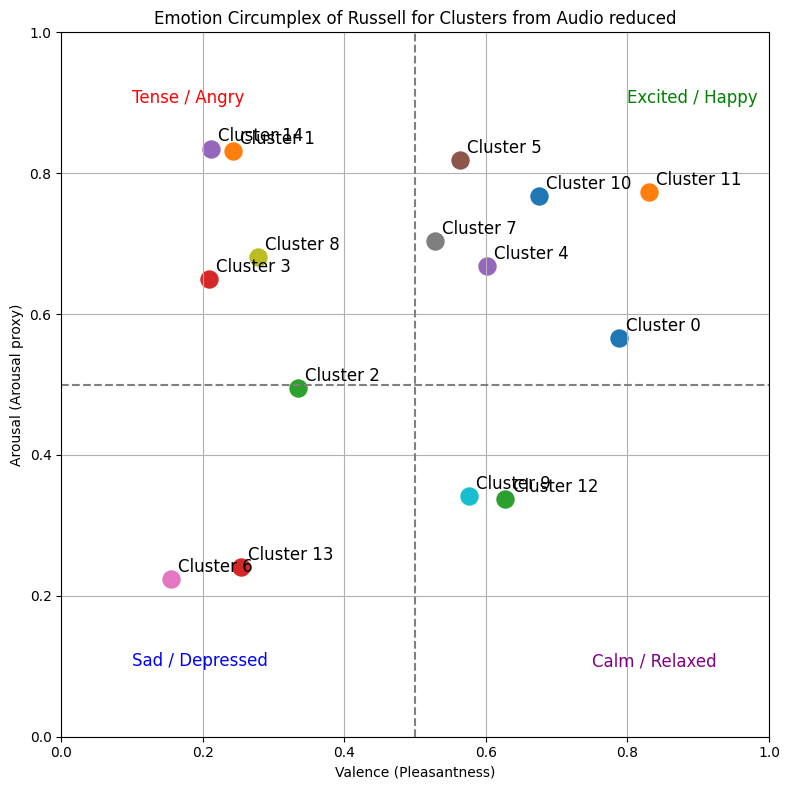

In [596]:
plot_emotion_circumplex_with_arousal(summary_stats_with_arousal, 'cluster_audio',name="Audio only",legend="(Arousal proxy)")

plot_emotion_circumplex_with_arousal(summary_stats_combined_with_arousal, 'cluster_combined',name="Audio + Genre",legend="(Arousal proxy)")

plot_emotion_circumplex_with_arousal(summary_stats_reduced_with_arousal, 'cluster_audio_reduced',name="Audio reduced",legend="(Arousal proxy)")

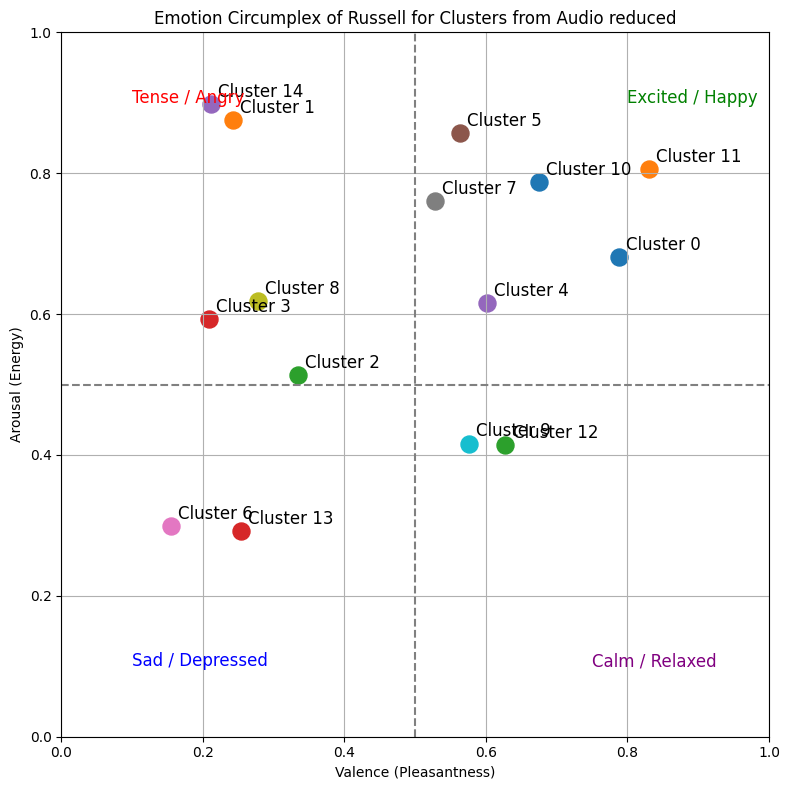

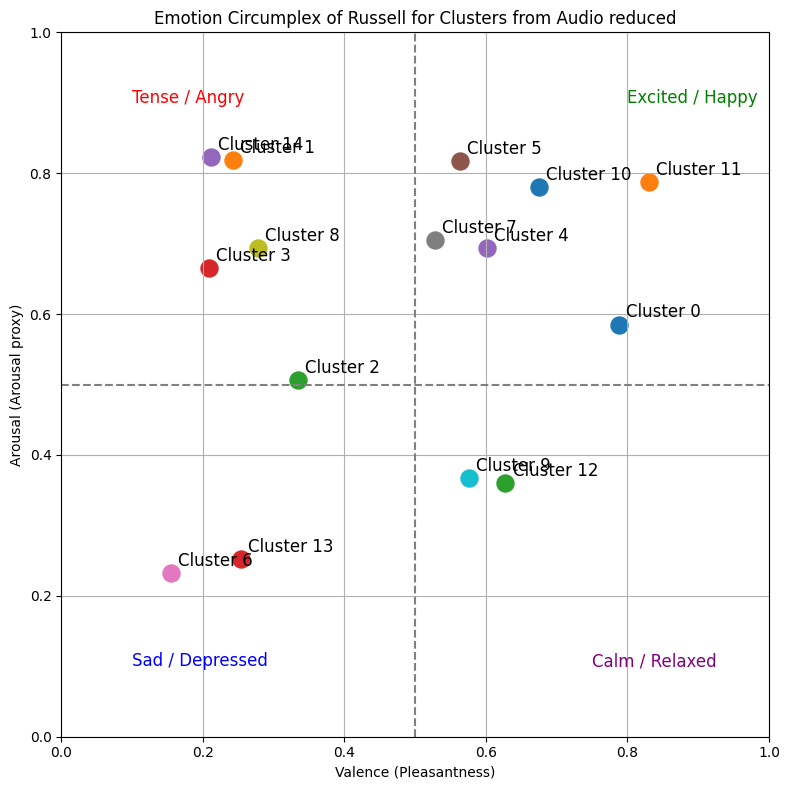

In [577]:
plot_emotion_circumplex(summary_stats_reduced, 'cluster_audio_reduced',name="Audio reduced",legend="(Energy)")
plot_emotion_circumplex_with_arousal(summary_stats_reduced_with_arousal, 'cluster_audio_reduced',name="Audio reduced",legend="(Arousal proxy)")


#Final emotion mapping

In [597]:
"""high >=0.6; 0.3<=mid<0.6; low<0.3"""

#Mapping based on distillRoberTA text emotion_classifier
def map_emotion(row):
  valence = row["valence_mean"]
  arousal = row["arousal_mean"]
  danceability = row["danceability_mean"]
  loudness = row["normalized_loudness_mean"]
  acousticness = row["acousticness_mean"]
  instrumentalness = row["instrumentalness_mean"]

  # Differentiate Anger and Fear if in ambiguous zone
  if valence < 0.35 and arousal > 0.65:
    if danceability > 0.5 and loudness > 0.7:
      return "Anger"
    elif acousticness > 0.4 or instrumentalness > 0.6:
      return "Fear"
    else:
      return "Anger"  #fallback

  if valence > 0.65 and arousal > 0.65:
    return "Joy"
  elif valence < 0.35 and arousal < 0.4:
    return "Sadness"
  elif valence < 0.35 and 0.4 <= arousal <= 0.65:
    return "Disgust"
  elif 0.35 <= valence <= 0.65 and arousal > 0.65:
    return "Surprise"
  elif 0.35 <= valence <= 0.65 and 0.4 <= arousal <= 0.65:
    return "Neutral"
  elif valence > 0.65 and 0.4 <= arousal <= 0.65:
    return "Joy"  # Still positive but calmer
  else:
    return "Neutral"

def assign_emotions_to_clusters(df):
    df = df.copy()
    df["emotion"] = df.apply(lambda row: map_emotion(row), axis=1)
    return df


In [598]:
# Cluster emotion
cluster_summary_with_emotions = assign_emotions_to_clusters(summary_stats_reduced_with_arousal)

# View with assigned emotions
print(cluster_summary_with_emotions[["cluster_audio_reduced","emotion"]])


    cluster_audio_reduced   emotion
0                       0       Joy
1                       1     Anger
2                       2   Disgust
3                       3   Disgust
4                       4  Surprise
5                       5  Surprise
6                       6   Sadness
7                       7  Surprise
8                       8     Anger
9                       9   Neutral
10                     10       Joy
11                     11       Joy
12                     12   Neutral
13                     13   Sadness
14                     14      Fear


Radar plot

In [599]:
def plot_cluster_radar_from_centroids(centroids_df, cluster_id):
    cluster_data = centroids_df.iloc[cluster_id]

    categories = cluster_data.index.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    values = cluster_data.tolist()
    values += values[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_rlabel_position(30)
    #plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=10)
    plt.yticks(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # the values of the circles
    ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"],  # their labels
    color="grey", size=10)
    plt.ylim(0, 1)
    plt.title(f'Centroid Feature Profile: Cluster {cluster_id}', size=15, y=1.1)
    plt.tight_layout()
    plt.show()

centroids_pca shape: (15, 6)
pca components shape: (6, 9)


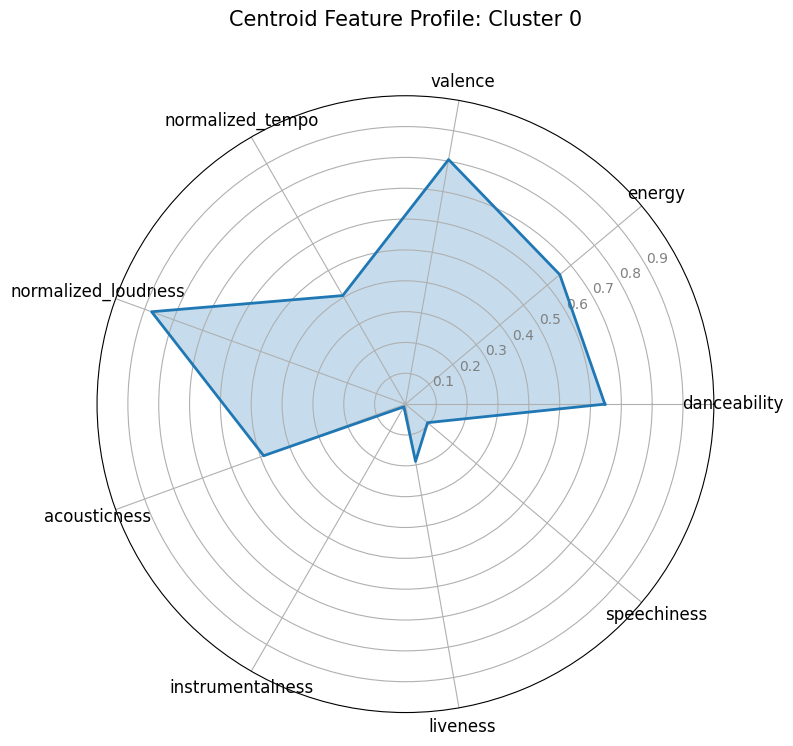

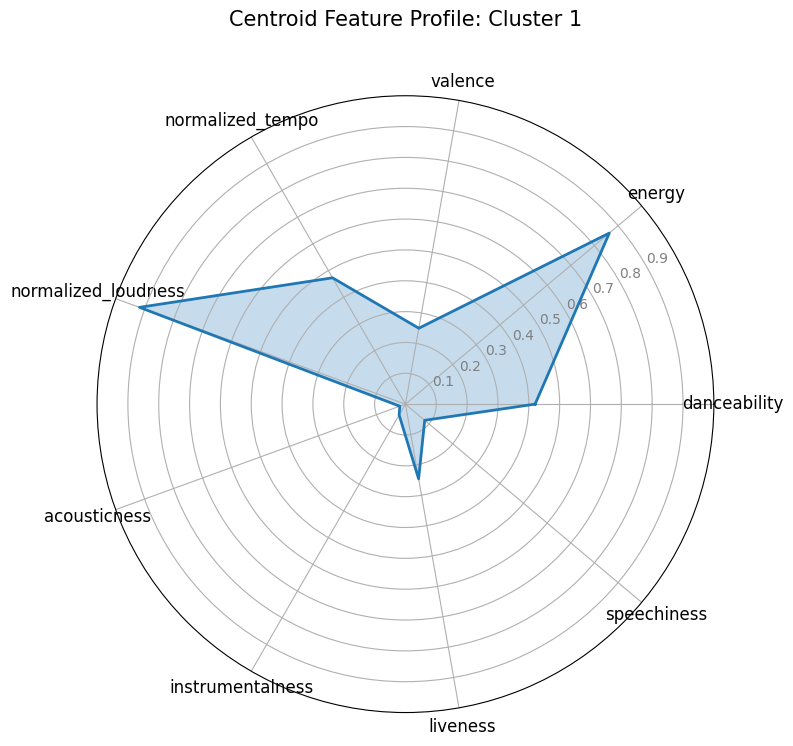

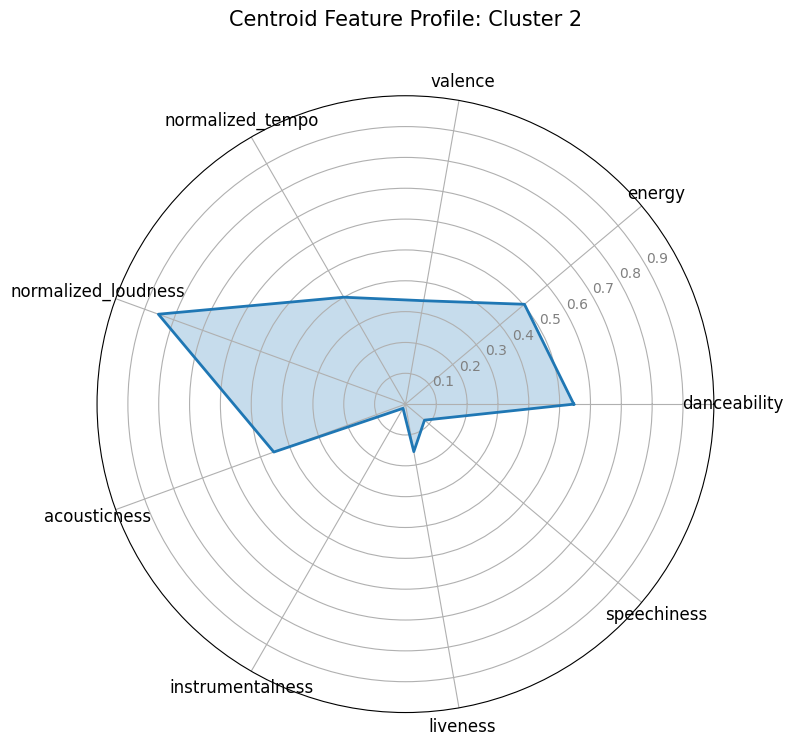

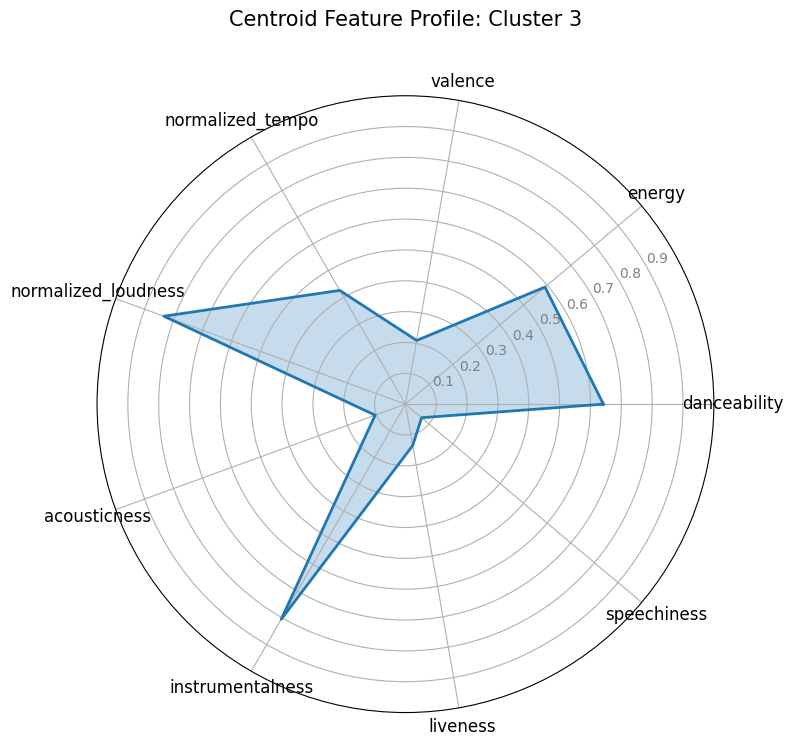

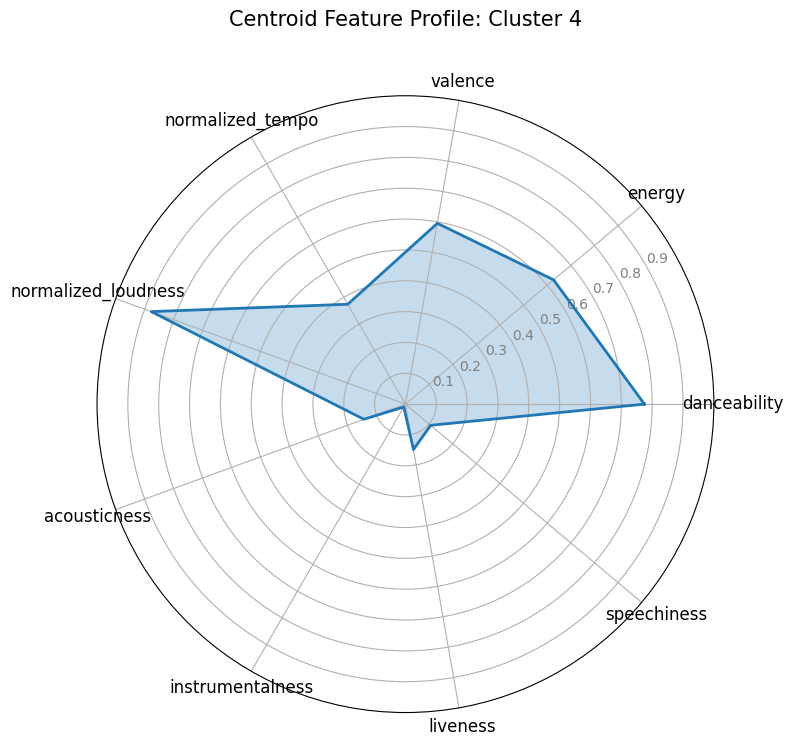

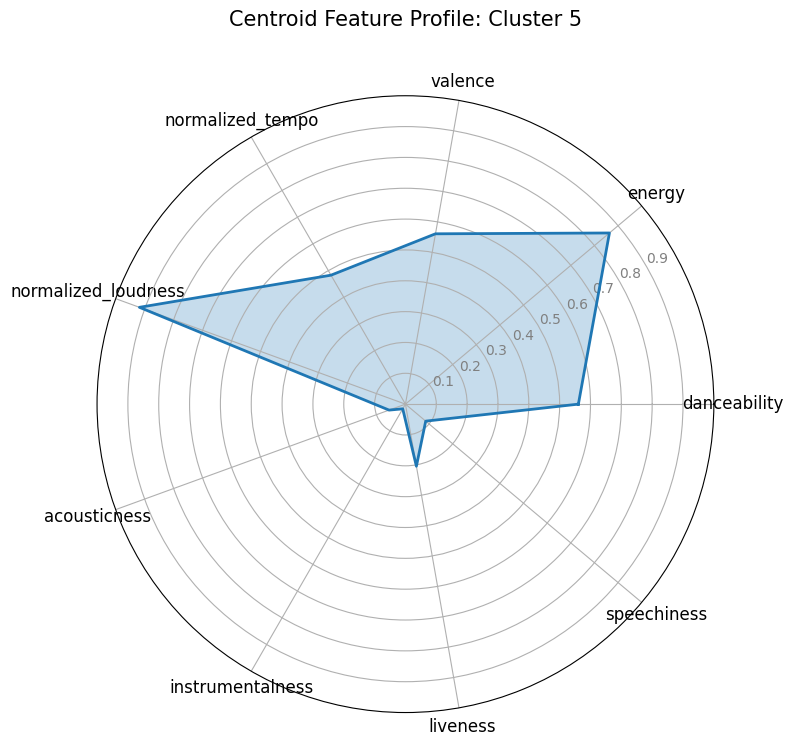

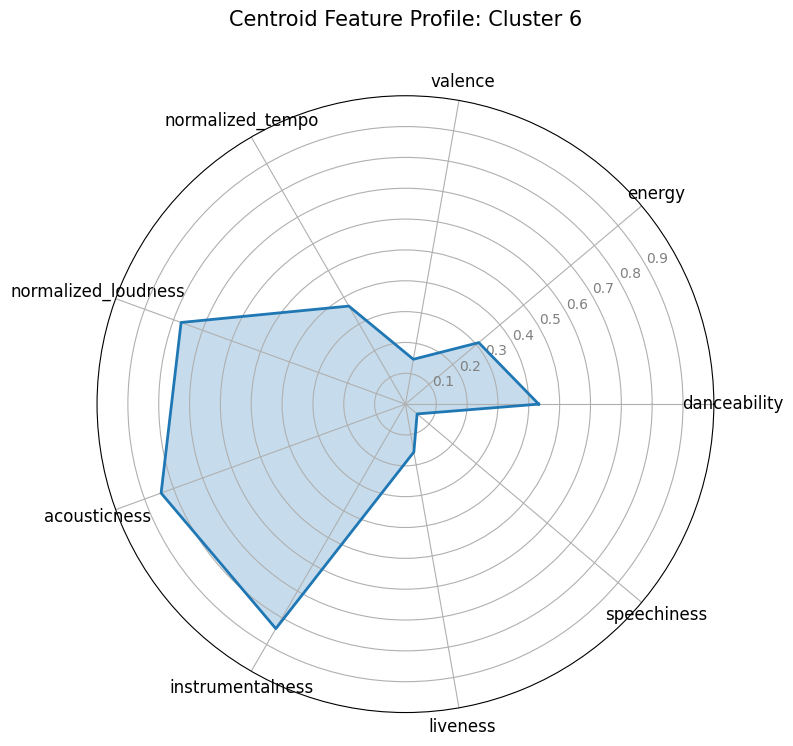

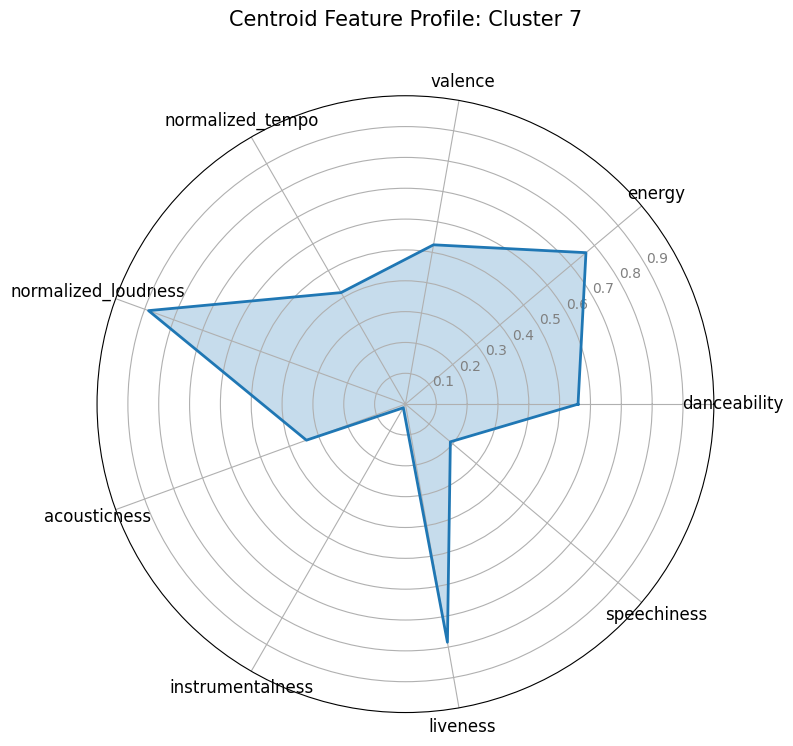

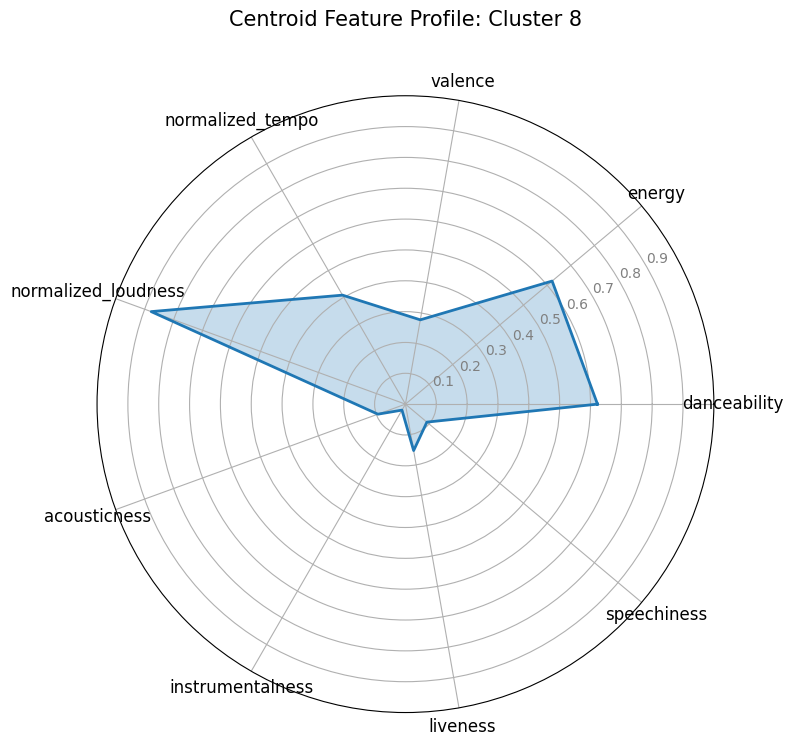

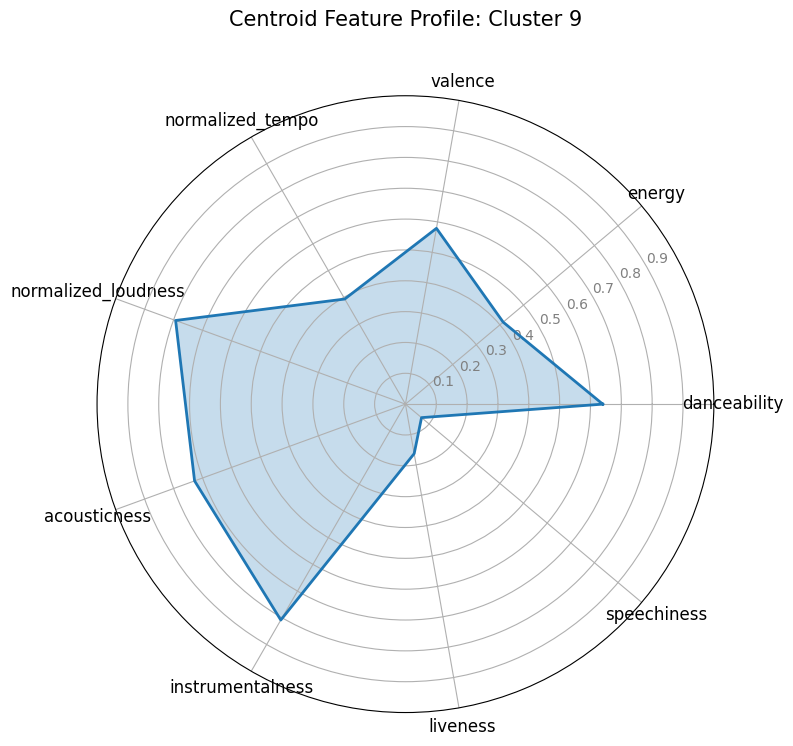

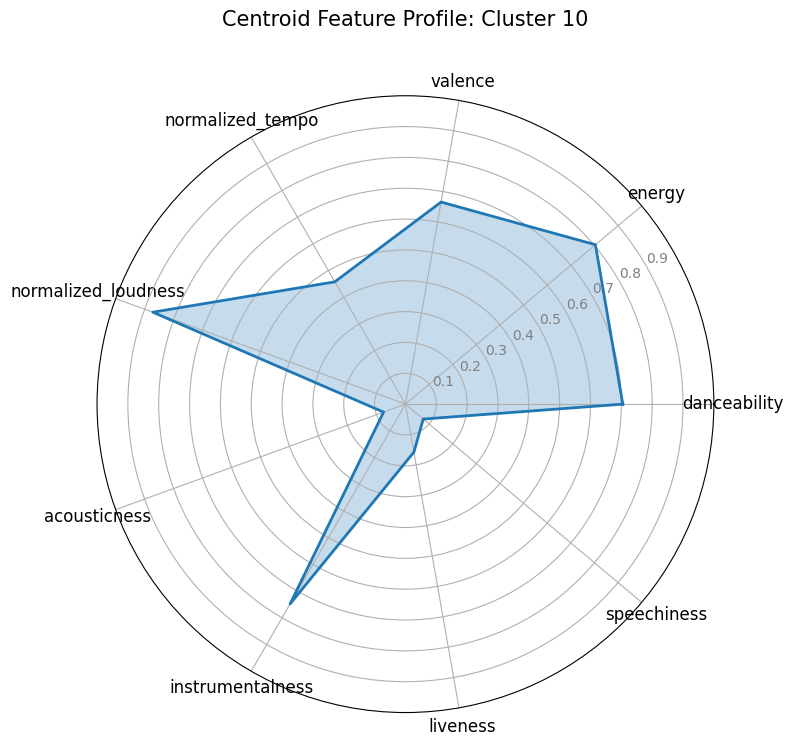

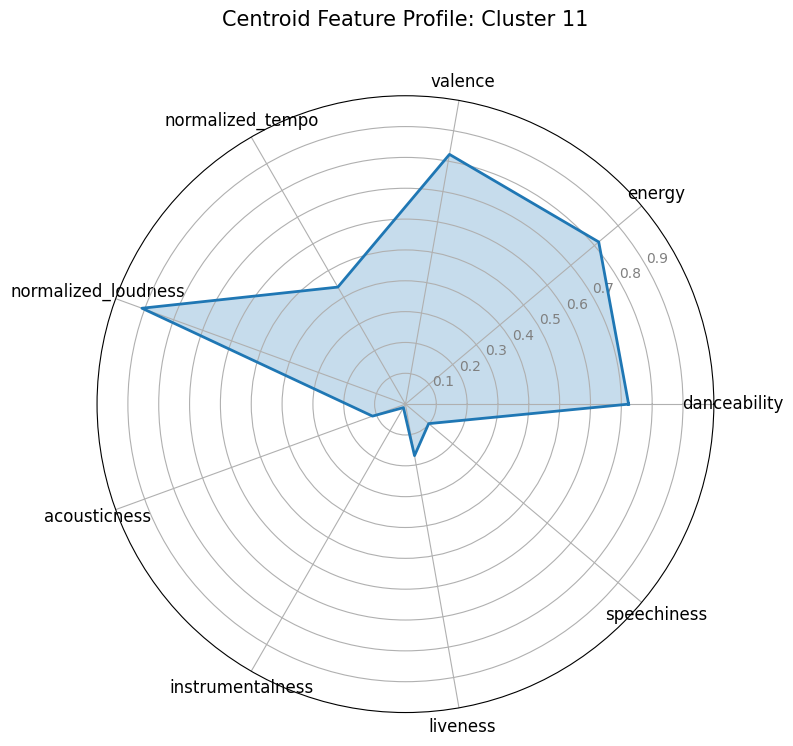

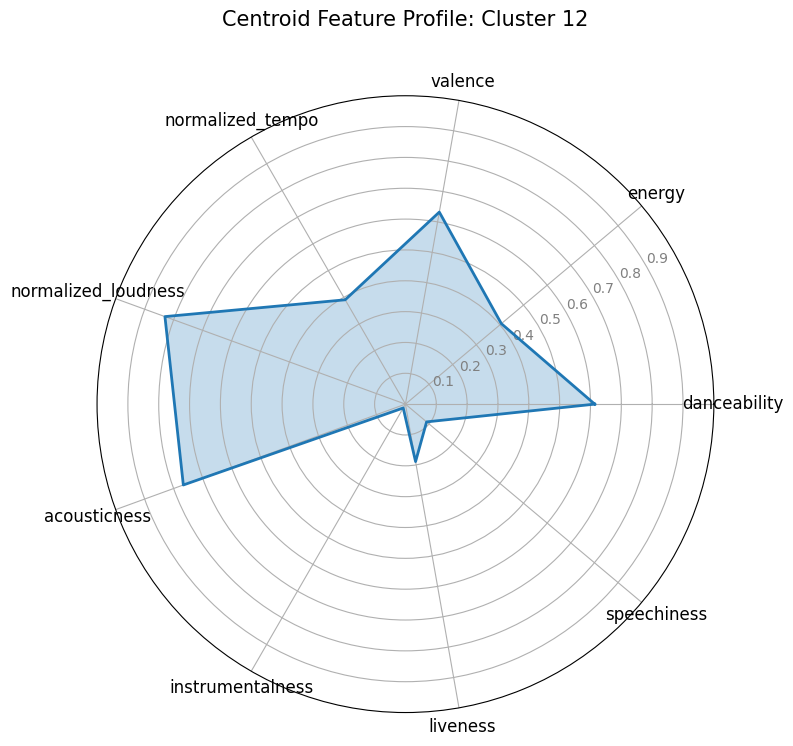

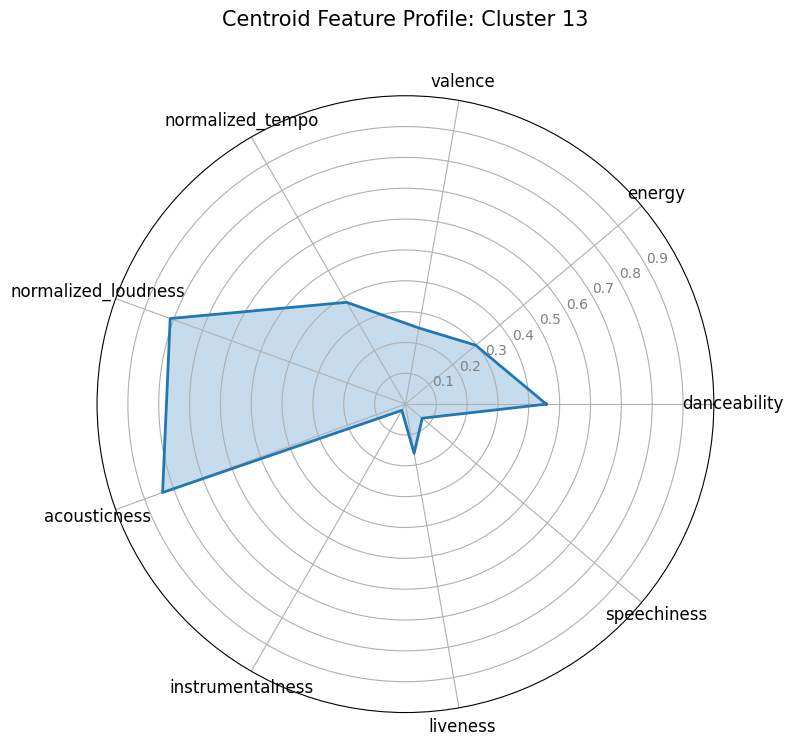

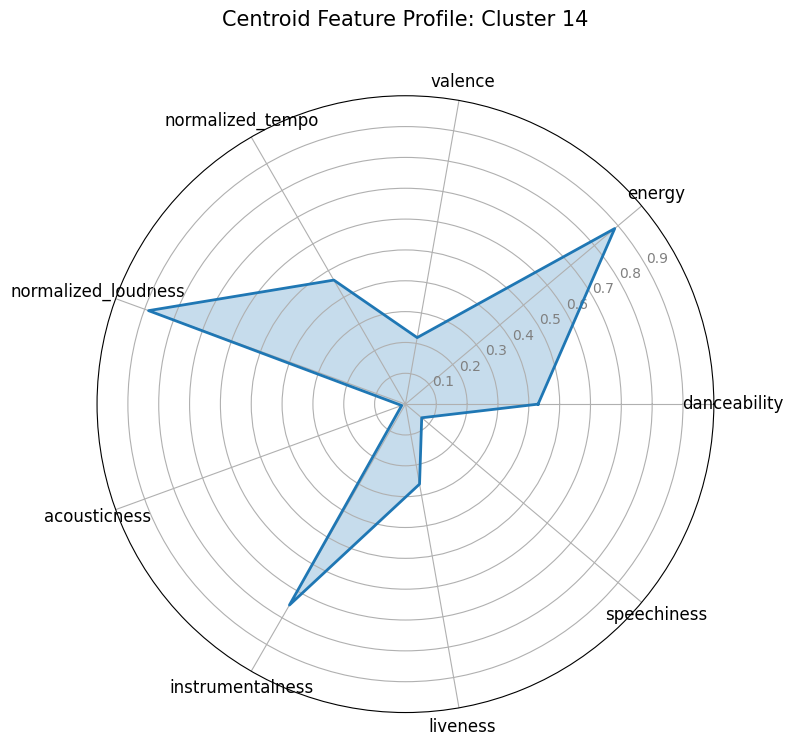

In [600]:
#reduced_features = pca.fit_transform(normalized_features)

centroids_pca = kmeans_audio_reduced.cluster_centers_
print("centroids_pca shape:", centroids_pca.shape)
print("pca components shape:", pca.components_.shape)

# If you want to transform the centroids back to the original space
centroids_original_space = pca.inverse_transform(centroids_pca)
centroids_df = pd.DataFrame(centroids_original_space, columns=audio_features)

for i in range(15):
    plot_cluster_radar_from_centroids(centroids_df, i)

